In [1]:
!pip freeze > ..//requirements.txt

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.tsa.stattools import (adfuller, 
                                       acf, pacf)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error, 
                             mean_absolute_percentage_error,
                             r2_score)
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

# hyperparameters tuning
from hyperopt import STATUS_OK, STATUS_FAIL, Trials, fmin, hp, tpe

In [3]:
# deixar data como indice
df = pd\
    .read_csv('../data/raw/dados_ibovespa.csv')\
    .rename(columns={
          'Data':'Date'
        , 'Último':'Close'
        , 'Abertura':'Open'
        , 'Máxima':'High'
        , 'Mínima':'Low'
        , 'Vol.':'Volume'
    })
df['Adj Close'] =  df['Close']
df.Date = pd.to_datetime(df['Date']).dt.date
df = df.sort_values(['Date'])
df['Datetime'] = pd.to_datetime(df['Date'])
df.Open = df.Open.astype(float)
df.Close = df.Close.astype(float)
df.High = df.High.astype(float)
df.Low = df.Low.astype(float)
df.Volume = df.Volume.str.replace('M','000000').str.replace(',','').str.replace('K','000')
df.Volume = df.Volume.astype(float)
df['Base Volume'] = df.Volume.astype(float)
df = df.sort_values(['Datetime'])

C:\Users\Pehls\AppData\Local\Temp\ipykernel_28336\3067610310.py:13: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.Date = pd.to_datetime(df['Date']).dt.date


# Grafico historico

In [4]:
len(df)

5589

In [5]:
min(df.Date), max(df.Date)

(datetime.date(2000, 12, 27), datetime.date(2023, 7, 21))

In [6]:
from indicators import Indicators, generate_graph
indicators = Indicators(settings='')

df, crossovers, ma_crossovers, bb_crossovers, hammers, suportes, resistencias, high_trend, low_trend, close_trend =  indicators.gen_all(df, 9999, macd_rsi_BB=False, rsi_window=14)

generate_graph(df, crossovers, just_candles=False)

One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

In [7]:
# serie e estacionaria? ADF - augmented dick-fuller
adfuller(df['Close'])

(-0.8924999370250177,
 0.7904322608539279,
 11,
 5577,
 {'1%': -3.4315230881147225,
  '5%': -2.862058389900819,
  '10%': -2.5670459375427312},
 16097.395332513242)

Test statistic was -1.624398
P-value was 0.47

so, we fail to reject the null hypothesis - or, we dont have constant variance over time, since this time series is non-stationary

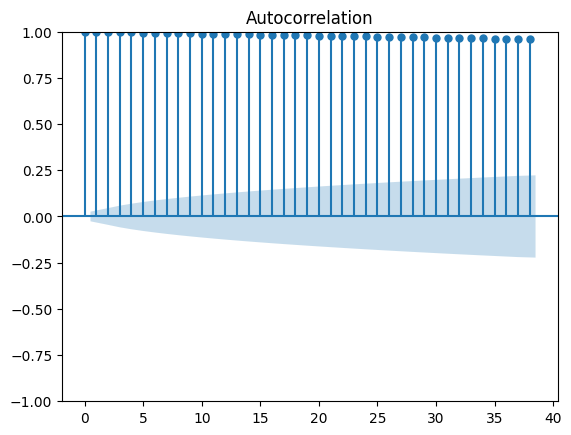

In [8]:
# ACF / PACF - autocorrelação e autocorrelação parcial 
# https://analyticsindiamag.com/what-are-autocorrelation-and-partial-autocorrelation-in-time-series-data/
acf_plot = plot_acf(df['Close'])

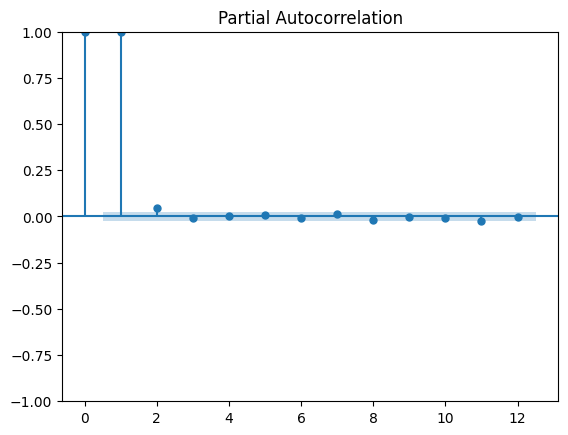

In [9]:
pacf_plot = plot_pacf(df['Close'], lags=12)

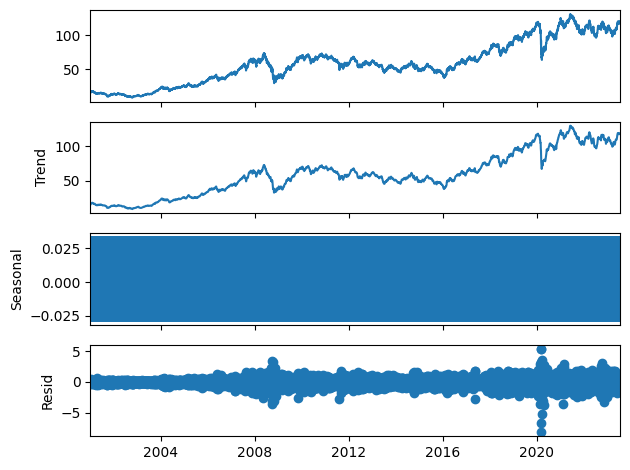

In [10]:
# componentes da serie
from statsmodels.tsa.seasonal import seasonal_decompose
series = df[['Close']]
series.index = pd.to_datetime(df.Date)
result = seasonal_decompose(series, model='additive', period=5)
result_plot = result.plot()


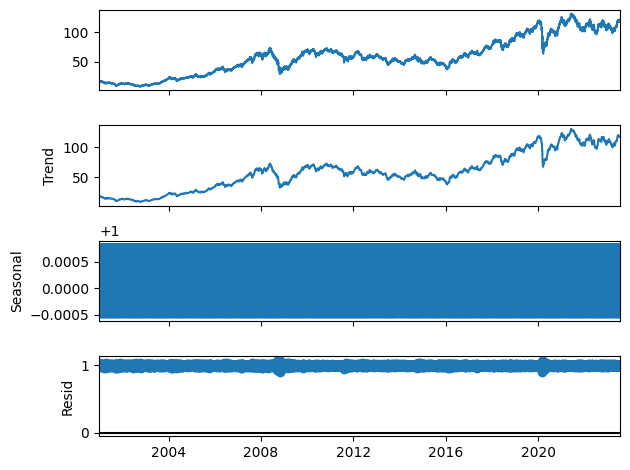

In [11]:
# componentes da serie - mult
from statsmodels.tsa.seasonal import seasonal_decompose
series = df[['Close']]
series.index = pd.to_datetime(df.Date)
result = seasonal_decompose(series, model='multiplicative', period=5)
result_plot = result.plot()


In [12]:
# normalização, como diferenciação, logaritmica ou com raízes

In [13]:
# previsao com arima

In [14]:
df.Date

Datetime
2000-12-27    2000-12-27
2000-12-28    2000-12-28
2001-01-02    2001-01-02
2001-01-03    2001-01-03
2001-01-04    2001-01-04
                 ...    
2023-07-17    2023-07-17
2023-07-18    2023-07-18
2023-07-19    2023-07-19
2023-07-20    2023-07-20
2023-07-21    2023-07-21
Name: Date, Length: 5589, dtype: object

In [15]:
# Prophet puro
_model = Prophet()
_res = []

_df = df.reset_index(drop=True)[['Date','Close']].rename(columns={'Date':'ds', 'Close':'y'})

train_end = pd.to_datetime('2023-01-01').date()
X_train = _df.loc[_df.ds < train_end]
X_test = _df.loc[_df.ds >= train_end]

_model.fit(X_train)
forecast_ = _model.predict(X_train)
pred = _model.predict(X_test)
_df = pd.concat([_df, _model.predict(_df)])

_res.append({
    'n_splits':0,
    'test_size':len(X_test),
    'regressors':'',
    'train_index':0,
    'test_index':min(X_test.index),
    'max_date_train':max(X_train.ds),
    'max_date_test':max(X_test.ds),
    'test_mape':mean_absolute_percentage_error(X_test['y'].values, pred['yhat'].values),
    'all_series_mape':mean_absolute_percentage_error(X_train['y'].values, forecast_["yhat"].values)
})

01:05:34 - cmdstanpy - INFO - Chain [1] start processing
01:05:35 - cmdstanpy - INFO - Chain [1] done processing


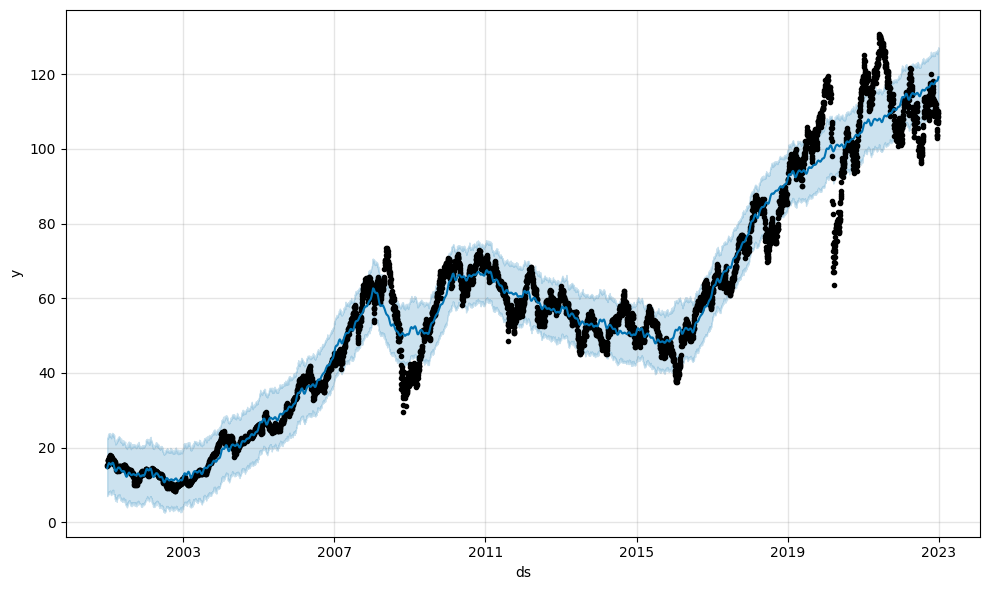

In [16]:
fig1 = _model.plot(forecast_)

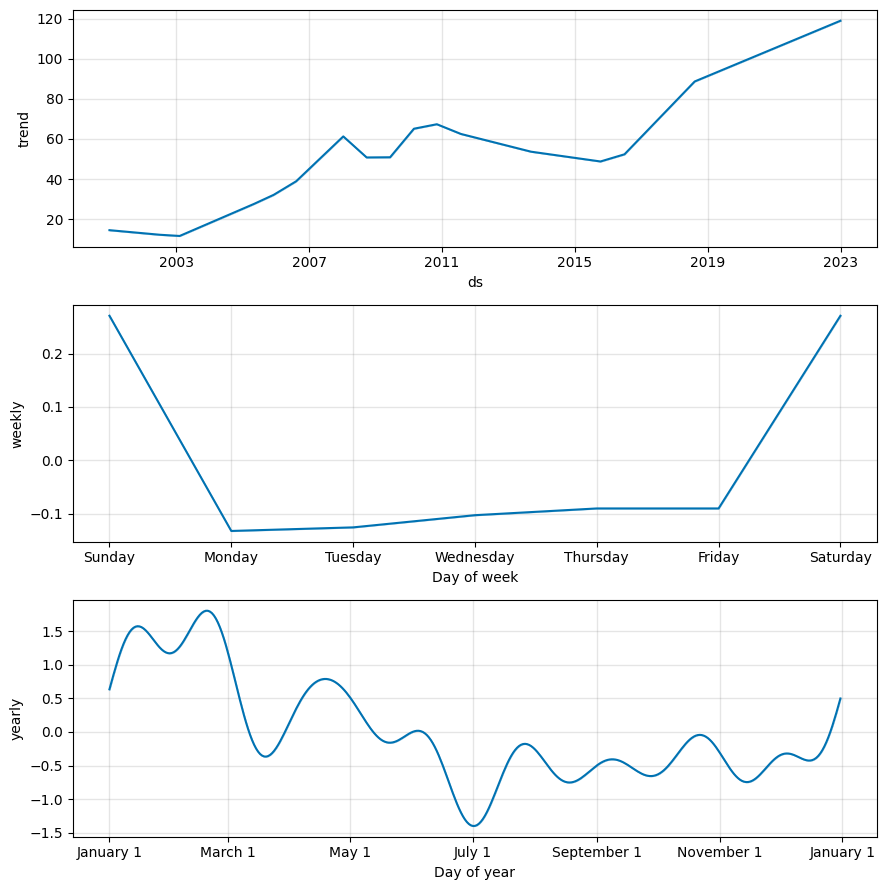

In [17]:
fig2 = _model.plot_components(forecast_)

In [18]:
# previsao com prophet + BCB como external variables

# hiperparametrização 

- time series split (sklearn) + bayesian search (hyperopt)

Select the search algorithm
The two main choices are:

* hyperopt.tpe.suggest: [Tree of Parzen Estimators](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f#:~:text=The%20Tree%20Parzen%20Estimator%20is,will%20explore%20in%20further%20articles.), a Bayesian approach that iteratively and adaptively selects new hyperparameter settings to explore based on previous results

* hyperopt.rand.suggest: Random search, a non-adaptive approach that samples over the search spac

In [23]:
# deixar data como indice
df = pd\
    .read_csv('../data/raw/dados_ibovespa.csv')\
    .rename(columns={
          'Data':'Date'
        , 'Último':'Close'
        , 'Abertura':'Open'
        , 'Máxima':'High'
        , 'Mínima':'Low'
        , 'Vol.':'Volume'
    })
df['Adj Close'] =  df['Close']
df.Date = pd.to_datetime(df['Date']).dt.date
df = df.sort_values(['Date'])
df['Datetime'] = pd.to_datetime(df['Date'])
df.Open = df.Open.astype(float)
df.Close = df.Close.astype(float)
df.High = df.High.astype(float)
df.Low = df.Low.astype(float)
df.Volume = df.Volume.str.replace('M','000000').str.replace(',','').str.replace('K','000')
df.Volume = df.Volume.astype(float)
df['Base Volume'] = df.Volume.astype(float)
df = df.sort_values(['Datetime'])

_df = df.reset_index(drop=True)[['Date','Close']].rename(columns={'Date':'ds', 'Close':'y'})

_df['ds'] = pd.to_datetime(_df['ds'])
_df = _df.reset_index()[['ds','y']]
_df

C:\Users\Pehls\AppData\Local\Temp\ipykernel_28336\1173881235.py:13: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



ds        y
0    2000-12-27   15.186
1    2000-12-28   15.259
2    2001-01-02   15.425
3    2001-01-03   16.599
4    2001-01-04   16.675
...         ...      ...
5584 2023-07-17  118.219
5585 2023-07-18  117.841
5586 2023-07-19  117.552
5587 2023-07-20  118.083
5588 2023-07-21  120.217

[5589 rows x 2 columns]

In [30]:
# previsao com prophet


# cross validation 
def _run_cv_prophet(df_model, best_params, n_splits = 5, test_size = 12,):
    tscv =  TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    for train_index, test_index in tscv.split(df_model):
        X_train, X_test = df_model.iloc[train_index], df_model.iloc[test_index]
        y_train, y_test = df_model.y[train_index], df_model.y[test_index]
        hyper_model = Prophet(
                yearly_seasonality=best_params["yearly_seasonality"],
                daily_seasonality=best_params["daily_seasonality"],
                weekly_seasonality=best_params["weekly_seasonality"],
                changepoint_prior_scale=best_params["changepoint_prior_scale"],
                changepoint_range=best_params["changepoint_range"])
        str_regressors = ''
        # for reg in best_params['regressors']:
        #     str_regressors += f'{reg["regressor_name"]}_'
        #     hyper_model.add_regressor(reg["regressor_name"], prior_scale=reg["prior_scale"], mode=reg["mode"])
        hyper_model.fit(X_train)
        forecast_ = hyper_model.predict(X_train)
        pred = hyper_model.predict(X_test)
        
        _res.append({
            'n_splits':n_splits,
            'test_size':test_size,
            'regressors':str_regressors,
            'train_index':train_index,
            'test_index':test_index,
            'max_date_train':max(X_train.ds),
            'max_date_test':max(X_test.ds),
            'test_mape':mean_absolute_percentage_error(y_test, pred['yhat'].values),
            'all_series_mape':mean_absolute_percentage_error(y_train, forecast_["yhat"].values)
        })
    return _res, pd.DataFrame(_res).test_mape.mean()

def objective(params):
   
    metrics, cv_mape = _run_cv_prophet(
                    df_model=_df.dropna(),
                    best_params=params,
                    n_splits=(10), test_size=31
                   )
    return cv_mape

space = {
    'yearly_seasonality':hp.choice('yearly_seasonality',[False]),
    'daily_seasonality':hp.choice('daily_seasonality',[False]),
    'weekly_seasonality':hp.choice('weekly_seasonality',[False]),
    "changepoint_prior_scale": hp.uniform("changepoint_prior_scale", 0, 2.5),
    "changepoint_range": hp.uniform("changepoint_range", 0, 1),
    "regressors":''
    # "regressors": hp.choice("regressors", [[{"regressor_name": reg,
    #                                          "prior_scale": hp.uniform(reg + "_prior_scale", 0, 20),
    #                                          "mode": hp.choice(reg + "_mode", ["additive"])
    #                                          } for reg in regressors]])
}


In [32]:
from hyperopt import space_eval
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, verbose=1)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

01:13:55 - cmdstanpy - INFO - Chain [1] start processing
01:13:55 - cmdstanpy - INFO - Chain [1] done processing
01:13:56 - cmdstanpy - INFO - Chain [1] start processing
01:13:57 - cmdstanpy - INFO - Chain [1] done processing
01:13:57 - cmdstanpy - INFO - Chain [1] start processing
01:13:58 - cmdstanpy - INFO - Chain [1] done processing
01:13:59 - cmdstanpy - INFO - Chain [1] start processing
01:14:00 - cmdstanpy - INFO - Chain [1] done processing
01:14:00 - cmdstanpy - INFO - Chain [1] start processing
01:14:02 - cmdstanpy - INFO - Chain [1] done processing
01:14:02 - cmdstanpy - INFO - Chain [1] start processing
01:14:03 - cmdstanpy - INFO - Chain [1] done processing
01:14:04 - cmdstanpy - INFO - Chain [1] start processing
01:14:05 - cmdstanpy - INFO - Chain [1] done processing
01:14:05 - cmdstanpy - INFO - Chain [1] start processing
01:14:07 - cmdstanpy - INFO - Chain [1] done processing
01:14:07 - cmdstanpy - INFO - Chain [1] start processing
01:14:08 - cmdstanpy - INFO - Chain [1]

  1%|          | 1/100 [00:15<25:45, 15.61s/trial, best loss: 0.0895486672003748]

01:14:10 - cmdstanpy - INFO - Chain [1] start processing
01:14:11 - cmdstanpy - INFO - Chain [1] done processing
01:14:12 - cmdstanpy - INFO - Chain [1] start processing
01:14:13 - cmdstanpy - INFO - Chain [1] done processing
01:14:14 - cmdstanpy - INFO - Chain [1] start processing
01:14:15 - cmdstanpy - INFO - Chain [1] done processing
01:14:15 - cmdstanpy - INFO - Chain [1] start processing
01:14:17 - cmdstanpy - INFO - Chain [1] done processing
01:14:17 - cmdstanpy - INFO - Chain [1] start processing
01:14:18 - cmdstanpy - INFO - Chain [1] done processing
01:14:18 - cmdstanpy - INFO - Chain [1] start processing
01:14:20 - cmdstanpy - INFO - Chain [1] done processing
01:14:20 - cmdstanpy - INFO - Chain [1] start processing
01:14:21 - cmdstanpy - INFO - Chain [1] done processing
01:14:22 - cmdstanpy - INFO - Chain [1] start processing
01:14:23 - cmdstanpy - INFO - Chain [1] done processing
01:14:23 - cmdstanpy - INFO - Chain [1] start processing
01:14:24 - cmdstanpy - INFO - Chain [1]

  2%|▏         | 2/100 [00:32<26:36, 16.30s/trial, best loss: 0.08645666787672744]

01:14:27 - cmdstanpy - INFO - Chain [1] start processing
01:14:29 - cmdstanpy - INFO - Chain [1] done processing
01:14:29 - cmdstanpy - INFO - Chain [1] start processing
01:14:30 - cmdstanpy - INFO - Chain [1] done processing
01:14:31 - cmdstanpy - INFO - Chain [1] start processing
01:14:32 - cmdstanpy - INFO - Chain [1] done processing
01:14:33 - cmdstanpy - INFO - Chain [1] start processing
01:14:34 - cmdstanpy - INFO - Chain [1] done processing
01:14:34 - cmdstanpy - INFO - Chain [1] start processing
01:14:35 - cmdstanpy - INFO - Chain [1] done processing
01:14:36 - cmdstanpy - INFO - Chain [1] start processing
01:14:37 - cmdstanpy - INFO - Chain [1] done processing
01:14:38 - cmdstanpy - INFO - Chain [1] start processing
01:14:39 - cmdstanpy - INFO - Chain [1] done processing
01:14:39 - cmdstanpy - INFO - Chain [1] start processing
01:14:40 - cmdstanpy - INFO - Chain [1] done processing
01:14:41 - cmdstanpy - INFO - Chain [1] start processing
01:14:42 - cmdstanpy - INFO - Chain [1]

  3%|▎         | 3/100 [00:49<27:13, 16.84s/trial, best loss: 0.08645666787672744]

01:14:44 - cmdstanpy - INFO - Chain [1] start processing
01:14:45 - cmdstanpy - INFO - Chain [1] done processing
01:14:45 - cmdstanpy - INFO - Chain [1] start processing
01:14:46 - cmdstanpy - INFO - Chain [1] done processing
01:14:46 - cmdstanpy - INFO - Chain [1] start processing
01:14:47 - cmdstanpy - INFO - Chain [1] done processing
01:14:47 - cmdstanpy - INFO - Chain [1] start processing
01:14:48 - cmdstanpy - INFO - Chain [1] done processing
01:14:49 - cmdstanpy - INFO - Chain [1] start processing
01:14:49 - cmdstanpy - INFO - Chain [1] done processing
01:14:50 - cmdstanpy - INFO - Chain [1] start processing
01:14:50 - cmdstanpy - INFO - Chain [1] done processing
01:14:51 - cmdstanpy - INFO - Chain [1] start processing
01:14:52 - cmdstanpy - INFO - Chain [1] done processing
01:14:52 - cmdstanpy - INFO - Chain [1] start processing
01:14:52 - cmdstanpy - INFO - Chain [1] done processing
01:14:53 - cmdstanpy - INFO - Chain [1] start processing
01:14:54 - cmdstanpy - INFO - Chain [1]

  4%|▍         | 4/100 [01:01<23:26, 14.65s/trial, best loss: 0.08645666787672744]

01:14:56 - cmdstanpy - INFO - Chain [1] start processing
01:14:57 - cmdstanpy - INFO - Chain [1] done processing
01:14:57 - cmdstanpy - INFO - Chain [1] start processing
01:14:58 - cmdstanpy - INFO - Chain [1] done processing
01:14:58 - cmdstanpy - INFO - Chain [1] start processing
01:14:59 - cmdstanpy - INFO - Chain [1] done processing
01:15:00 - cmdstanpy - INFO - Chain [1] start processing
01:15:01 - cmdstanpy - INFO - Chain [1] done processing
01:15:01 - cmdstanpy - INFO - Chain [1] start processing
01:15:02 - cmdstanpy - INFO - Chain [1] done processing
01:15:03 - cmdstanpy - INFO - Chain [1] start processing
01:15:04 - cmdstanpy - INFO - Chain [1] done processing
01:15:05 - cmdstanpy - INFO - Chain [1] start processing
01:15:06 - cmdstanpy - INFO - Chain [1] done processing
01:15:07 - cmdstanpy - INFO - Chain [1] start processing
01:15:08 - cmdstanpy - INFO - Chain [1] done processing
01:15:09 - cmdstanpy - INFO - Chain [1] start processing
01:15:10 - cmdstanpy - INFO - Chain [1]

  5%|▌         | 5/100 [01:18<24:43, 15.61s/trial, best loss: 0.08645666787672744]

01:15:13 - cmdstanpy - INFO - Chain [1] start processing
01:15:15 - cmdstanpy - INFO - Chain [1] done processing
01:15:16 - cmdstanpy - INFO - Chain [1] start processing
01:15:17 - cmdstanpy - INFO - Chain [1] done processing
01:15:18 - cmdstanpy - INFO - Chain [1] start processing
01:15:19 - cmdstanpy - INFO - Chain [1] done processing
01:15:20 - cmdstanpy - INFO - Chain [1] start processing
01:15:22 - cmdstanpy - INFO - Chain [1] done processing
01:15:23 - cmdstanpy - INFO - Chain [1] start processing
01:15:24 - cmdstanpy - INFO - Chain [1] done processing
01:15:25 - cmdstanpy - INFO - Chain [1] start processing
01:15:27 - cmdstanpy - INFO - Chain [1] done processing
01:15:28 - cmdstanpy - INFO - Chain [1] start processing
01:15:29 - cmdstanpy - INFO - Chain [1] done processing
01:15:31 - cmdstanpy - INFO - Chain [1] start processing
01:15:32 - cmdstanpy - INFO - Chain [1] done processing
01:15:33 - cmdstanpy - INFO - Chain [1] start processing
01:15:35 - cmdstanpy - INFO - Chain [1]

  6%|▌         | 6/100 [01:43<29:41, 18.95s/trial, best loss: 0.08645666787672744]

01:15:39 - cmdstanpy - INFO - Chain [1] start processing
01:15:40 - cmdstanpy - INFO - Chain [1] done processing
01:15:41 - cmdstanpy - INFO - Chain [1] start processing
01:15:41 - cmdstanpy - INFO - Chain [1] done processing
01:15:42 - cmdstanpy - INFO - Chain [1] start processing
01:15:43 - cmdstanpy - INFO - Chain [1] done processing
01:15:44 - cmdstanpy - INFO - Chain [1] start processing
01:15:45 - cmdstanpy - INFO - Chain [1] done processing
01:15:46 - cmdstanpy - INFO - Chain [1] start processing
01:15:47 - cmdstanpy - INFO - Chain [1] done processing
01:15:48 - cmdstanpy - INFO - Chain [1] start processing
01:15:49 - cmdstanpy - INFO - Chain [1] done processing
01:15:50 - cmdstanpy - INFO - Chain [1] start processing
01:15:50 - cmdstanpy - INFO - Chain [1] done processing
01:15:51 - cmdstanpy - INFO - Chain [1] start processing
01:15:52 - cmdstanpy - INFO - Chain [1] done processing
01:15:53 - cmdstanpy - INFO - Chain [1] start processing
01:15:53 - cmdstanpy - INFO - Chain [1]

  7%|▋         | 7/100 [02:01<28:30, 18.39s/trial, best loss: 0.08645666787672744]

01:15:56 - cmdstanpy - INFO - Chain [1] start processing
01:15:57 - cmdstanpy - INFO - Chain [1] done processing
01:15:57 - cmdstanpy - INFO - Chain [1] start processing
01:15:58 - cmdstanpy - INFO - Chain [1] done processing
01:15:59 - cmdstanpy - INFO - Chain [1] start processing
01:16:00 - cmdstanpy - INFO - Chain [1] done processing
01:16:01 - cmdstanpy - INFO - Chain [1] start processing
01:16:02 - cmdstanpy - INFO - Chain [1] done processing
01:16:02 - cmdstanpy - INFO - Chain [1] start processing
01:16:03 - cmdstanpy - INFO - Chain [1] done processing
01:16:04 - cmdstanpy - INFO - Chain [1] start processing
01:16:05 - cmdstanpy - INFO - Chain [1] done processing
01:16:06 - cmdstanpy - INFO - Chain [1] start processing
01:16:07 - cmdstanpy - INFO - Chain [1] done processing
01:16:08 - cmdstanpy - INFO - Chain [1] start processing
01:16:09 - cmdstanpy - INFO - Chain [1] done processing
01:16:10 - cmdstanpy - INFO - Chain [1] start processing
01:16:11 - cmdstanpy - INFO - Chain [1]

  8%|▊         | 8/100 [02:18<27:46, 18.11s/trial, best loss: 0.08645666787672744]

01:16:14 - cmdstanpy - INFO - Chain [1] start processing
01:16:15 - cmdstanpy - INFO - Chain [1] done processing
01:16:16 - cmdstanpy - INFO - Chain [1] start processing
01:16:18 - cmdstanpy - INFO - Chain [1] done processing
01:16:19 - cmdstanpy - INFO - Chain [1] start processing
01:16:21 - cmdstanpy - INFO - Chain [1] done processing
01:16:22 - cmdstanpy - INFO - Chain [1] start processing
01:16:24 - cmdstanpy - INFO - Chain [1] done processing
01:16:25 - cmdstanpy - INFO - Chain [1] start processing
01:16:26 - cmdstanpy - INFO - Chain [1] done processing
01:16:27 - cmdstanpy - INFO - Chain [1] start processing
01:16:29 - cmdstanpy - INFO - Chain [1] done processing
01:16:30 - cmdstanpy - INFO - Chain [1] start processing
01:16:32 - cmdstanpy - INFO - Chain [1] done processing
01:16:33 - cmdstanpy - INFO - Chain [1] start processing
01:16:35 - cmdstanpy - INFO - Chain [1] done processing
01:16:36 - cmdstanpy - INFO - Chain [1] start processing
01:16:37 - cmdstanpy - INFO - Chain [1]

  9%|▉         | 9/100 [02:45<31:26, 20.73s/trial, best loss: 0.08645666787672744]

01:16:40 - cmdstanpy - INFO - Chain [1] start processing
01:16:41 - cmdstanpy - INFO - Chain [1] done processing
01:16:42 - cmdstanpy - INFO - Chain [1] start processing
01:16:43 - cmdstanpy - INFO - Chain [1] done processing
01:16:44 - cmdstanpy - INFO - Chain [1] start processing
01:16:45 - cmdstanpy - INFO - Chain [1] done processing
01:16:46 - cmdstanpy - INFO - Chain [1] start processing
01:16:47 - cmdstanpy - INFO - Chain [1] done processing
01:16:48 - cmdstanpy - INFO - Chain [1] start processing
01:16:49 - cmdstanpy - INFO - Chain [1] done processing
01:16:50 - cmdstanpy - INFO - Chain [1] start processing
01:16:52 - cmdstanpy - INFO - Chain [1] done processing
01:16:53 - cmdstanpy - INFO - Chain [1] start processing
01:16:54 - cmdstanpy - INFO - Chain [1] done processing
01:16:55 - cmdstanpy - INFO - Chain [1] start processing
01:16:57 - cmdstanpy - INFO - Chain [1] done processing
01:16:58 - cmdstanpy - INFO - Chain [1] start processing
01:17:00 - cmdstanpy - INFO - Chain [1]

 10%|█         | 10/100 [03:08<32:17, 21.53s/trial, best loss: 0.08645666787672744]

01:17:04 - cmdstanpy - INFO - Chain [1] start processing
01:17:05 - cmdstanpy - INFO - Chain [1] done processing
01:17:06 - cmdstanpy - INFO - Chain [1] start processing
01:17:07 - cmdstanpy - INFO - Chain [1] done processing
01:17:08 - cmdstanpy - INFO - Chain [1] start processing
01:17:09 - cmdstanpy - INFO - Chain [1] done processing
01:17:10 - cmdstanpy - INFO - Chain [1] start processing
01:17:12 - cmdstanpy - INFO - Chain [1] done processing
01:17:13 - cmdstanpy - INFO - Chain [1] start processing
01:17:14 - cmdstanpy - INFO - Chain [1] done processing
01:17:16 - cmdstanpy - INFO - Chain [1] start processing
01:17:17 - cmdstanpy - INFO - Chain [1] done processing
01:17:18 - cmdstanpy - INFO - Chain [1] start processing
01:17:19 - cmdstanpy - INFO - Chain [1] done processing
01:17:20 - cmdstanpy - INFO - Chain [1] start processing
01:17:22 - cmdstanpy - INFO - Chain [1] done processing
01:17:22 - cmdstanpy - INFO - Chain [1] start processing
01:17:24 - cmdstanpy - INFO - Chain [1]

 11%|█         | 11/100 [03:31<32:47, 22.11s/trial, best loss: 0.08645666787672744]

01:17:26 - cmdstanpy - INFO - Chain [1] start processing
01:17:27 - cmdstanpy - INFO - Chain [1] done processing
01:17:28 - cmdstanpy - INFO - Chain [1] start processing
01:17:30 - cmdstanpy - INFO - Chain [1] done processing
01:17:31 - cmdstanpy - INFO - Chain [1] start processing
01:17:31 - cmdstanpy - INFO - Chain [1] done processing
01:17:32 - cmdstanpy - INFO - Chain [1] start processing
01:17:34 - cmdstanpy - INFO - Chain [1] done processing
01:17:35 - cmdstanpy - INFO - Chain [1] start processing
01:17:36 - cmdstanpy - INFO - Chain [1] done processing
01:17:36 - cmdstanpy - INFO - Chain [1] start processing
01:17:37 - cmdstanpy - INFO - Chain [1] done processing
01:17:38 - cmdstanpy - INFO - Chain [1] start processing
01:17:39 - cmdstanpy - INFO - Chain [1] done processing
01:17:40 - cmdstanpy - INFO - Chain [1] start processing
01:17:41 - cmdstanpy - INFO - Chain [1] done processing
01:17:42 - cmdstanpy - INFO - Chain [1] start processing
01:17:43 - cmdstanpy - INFO - Chain [1]

 12%|█▏        | 12/100 [03:50<31:03, 21.18s/trial, best loss: 0.08645666787672744]

01:17:46 - cmdstanpy - INFO - Chain [1] start processing
01:17:47 - cmdstanpy - INFO - Chain [1] done processing
01:17:48 - cmdstanpy - INFO - Chain [1] start processing
01:17:51 - cmdstanpy - INFO - Chain [1] done processing
01:17:52 - cmdstanpy - INFO - Chain [1] start processing
01:17:53 - cmdstanpy - INFO - Chain [1] done processing
01:17:54 - cmdstanpy - INFO - Chain [1] start processing
01:17:56 - cmdstanpy - INFO - Chain [1] done processing
01:17:57 - cmdstanpy - INFO - Chain [1] start processing
01:17:59 - cmdstanpy - INFO - Chain [1] done processing
01:18:00 - cmdstanpy - INFO - Chain [1] start processing
01:18:01 - cmdstanpy - INFO - Chain [1] done processing
01:18:02 - cmdstanpy - INFO - Chain [1] start processing
01:18:04 - cmdstanpy - INFO - Chain [1] done processing
01:18:05 - cmdstanpy - INFO - Chain [1] start processing
01:18:06 - cmdstanpy - INFO - Chain [1] done processing
01:18:07 - cmdstanpy - INFO - Chain [1] start processing
01:18:09 - cmdstanpy - INFO - Chain [1]

 13%|█▎        | 13/100 [04:16<32:41, 22.54s/trial, best loss: 0.08645666787672744]

01:18:12 - cmdstanpy - INFO - Chain [1] start processing
01:18:12 - cmdstanpy - INFO - Chain [1] done processing
01:18:13 - cmdstanpy - INFO - Chain [1] start processing
01:18:14 - cmdstanpy - INFO - Chain [1] done processing
01:18:14 - cmdstanpy - INFO - Chain [1] start processing
01:18:15 - cmdstanpy - INFO - Chain [1] done processing
01:18:16 - cmdstanpy - INFO - Chain [1] start processing
01:18:17 - cmdstanpy - INFO - Chain [1] done processing
01:18:18 - cmdstanpy - INFO - Chain [1] start processing
01:18:19 - cmdstanpy - INFO - Chain [1] done processing
01:18:20 - cmdstanpy - INFO - Chain [1] start processing
01:18:21 - cmdstanpy - INFO - Chain [1] done processing
01:18:22 - cmdstanpy - INFO - Chain [1] start processing
01:18:23 - cmdstanpy - INFO - Chain [1] done processing
01:18:24 - cmdstanpy - INFO - Chain [1] start processing
01:18:25 - cmdstanpy - INFO - Chain [1] done processing
01:18:26 - cmdstanpy - INFO - Chain [1] start processing
01:18:27 - cmdstanpy - INFO - Chain [1]

 14%|█▍        | 14/100 [04:35<30:47, 21.48s/trial, best loss: 0.08645666787672744]

01:18:31 - cmdstanpy - INFO - Chain [1] start processing
01:18:32 - cmdstanpy - INFO - Chain [1] done processing
01:18:33 - cmdstanpy - INFO - Chain [1] start processing
01:18:35 - cmdstanpy - INFO - Chain [1] done processing
01:18:36 - cmdstanpy - INFO - Chain [1] start processing
01:18:37 - cmdstanpy - INFO - Chain [1] done processing
01:18:38 - cmdstanpy - INFO - Chain [1] start processing
01:18:40 - cmdstanpy - INFO - Chain [1] done processing
01:18:41 - cmdstanpy - INFO - Chain [1] start processing
01:18:42 - cmdstanpy - INFO - Chain [1] done processing
01:18:43 - cmdstanpy - INFO - Chain [1] start processing
01:18:45 - cmdstanpy - INFO - Chain [1] done processing
01:18:46 - cmdstanpy - INFO - Chain [1] start processing
01:18:48 - cmdstanpy - INFO - Chain [1] done processing
01:18:49 - cmdstanpy - INFO - Chain [1] start processing
01:18:50 - cmdstanpy - INFO - Chain [1] done processing
01:18:51 - cmdstanpy - INFO - Chain [1] start processing
01:18:53 - cmdstanpy - INFO - Chain [1]

 15%|█▌        | 15/100 [05:01<32:11, 22.72s/trial, best loss: 0.08645666787672744]

01:18:56 - cmdstanpy - INFO - Chain [1] start processing
01:18:57 - cmdstanpy - INFO - Chain [1] done processing
01:18:58 - cmdstanpy - INFO - Chain [1] start processing
01:19:00 - cmdstanpy - INFO - Chain [1] done processing
01:19:00 - cmdstanpy - INFO - Chain [1] start processing
01:19:02 - cmdstanpy - INFO - Chain [1] done processing
01:19:03 - cmdstanpy - INFO - Chain [1] start processing
01:19:04 - cmdstanpy - INFO - Chain [1] done processing
01:19:05 - cmdstanpy - INFO - Chain [1] start processing
01:19:07 - cmdstanpy - INFO - Chain [1] done processing
01:19:07 - cmdstanpy - INFO - Chain [1] start processing
01:19:09 - cmdstanpy - INFO - Chain [1] done processing
01:19:10 - cmdstanpy - INFO - Chain [1] start processing
01:19:12 - cmdstanpy - INFO - Chain [1] done processing
01:19:12 - cmdstanpy - INFO - Chain [1] start processing
01:19:14 - cmdstanpy - INFO - Chain [1] done processing
01:19:15 - cmdstanpy - INFO - Chain [1] start processing
01:19:17 - cmdstanpy - INFO - Chain [1]

 16%|█▌        | 16/100 [05:25<32:23, 23.13s/trial, best loss: 0.08645666787672744]

01:19:20 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1] done processing
01:19:22 - cmdstanpy - INFO - Chain [1] start processing
01:19:23 - cmdstanpy - INFO - Chain [1] done processing
01:19:24 - cmdstanpy - INFO - Chain [1] start processing
01:19:25 - cmdstanpy - INFO - Chain [1] done processing
01:19:26 - cmdstanpy - INFO - Chain [1] start processing
01:19:27 - cmdstanpy - INFO - Chain [1] done processing
01:19:28 - cmdstanpy - INFO - Chain [1] start processing
01:19:29 - cmdstanpy - INFO - Chain [1] done processing
01:19:30 - cmdstanpy - INFO - Chain [1] start processing
01:19:32 - cmdstanpy - INFO - Chain [1] done processing
01:19:32 - cmdstanpy - INFO - Chain [1] start processing
01:19:34 - cmdstanpy - INFO - Chain [1] done processing
01:19:35 - cmdstanpy - INFO - Chain [1] start processing
01:19:36 - cmdstanpy - INFO - Chain [1] done processing
01:19:37 - cmdstanpy - INFO - Chain [1] start processing
01:19:38 - cmdstanpy - INFO - Chain [1]

 17%|█▋        | 17/100 [05:45<30:44, 22.22s/trial, best loss: 0.08645666787672744]

01:19:40 - cmdstanpy - INFO - Chain [1] start processing
01:19:42 - cmdstanpy - INFO - Chain [1] done processing
01:19:43 - cmdstanpy - INFO - Chain [1] start processing
01:19:44 - cmdstanpy - INFO - Chain [1] done processing
01:19:45 - cmdstanpy - INFO - Chain [1] start processing
01:19:46 - cmdstanpy - INFO - Chain [1] done processing
01:19:47 - cmdstanpy - INFO - Chain [1] start processing
01:19:48 - cmdstanpy - INFO - Chain [1] done processing
01:19:49 - cmdstanpy - INFO - Chain [1] start processing
01:19:50 - cmdstanpy - INFO - Chain [1] done processing
01:19:52 - cmdstanpy - INFO - Chain [1] start processing
01:19:53 - cmdstanpy - INFO - Chain [1] done processing
01:19:54 - cmdstanpy - INFO - Chain [1] start processing
01:19:56 - cmdstanpy - INFO - Chain [1] done processing
01:19:57 - cmdstanpy - INFO - Chain [1] start processing
01:19:59 - cmdstanpy - INFO - Chain [1] done processing
01:20:00 - cmdstanpy - INFO - Chain [1] start processing
01:20:02 - cmdstanpy - INFO - Chain [1]

 18%|█▊        | 18/100 [06:10<31:37, 23.14s/trial, best loss: 0.0857315132495652] 

01:20:06 - cmdstanpy - INFO - Chain [1] start processing
01:20:08 - cmdstanpy - INFO - Chain [1] done processing
01:20:09 - cmdstanpy - INFO - Chain [1] start processing
01:20:11 - cmdstanpy - INFO - Chain [1] done processing
01:20:12 - cmdstanpy - INFO - Chain [1] start processing
01:20:13 - cmdstanpy - INFO - Chain [1] done processing
01:20:14 - cmdstanpy - INFO - Chain [1] start processing
01:20:16 - cmdstanpy - INFO - Chain [1] done processing
01:20:17 - cmdstanpy - INFO - Chain [1] start processing
01:20:19 - cmdstanpy - INFO - Chain [1] done processing
01:20:20 - cmdstanpy - INFO - Chain [1] start processing
01:20:21 - cmdstanpy - INFO - Chain [1] done processing
01:20:22 - cmdstanpy - INFO - Chain [1] start processing
01:20:24 - cmdstanpy - INFO - Chain [1] done processing
01:20:24 - cmdstanpy - INFO - Chain [1] start processing
01:20:26 - cmdstanpy - INFO - Chain [1] done processing
01:20:26 - cmdstanpy - INFO - Chain [1] start processing
01:20:28 - cmdstanpy - INFO - Chain [1]

 19%|█▉        | 19/100 [06:36<32:14, 23.88s/trial, best loss: 0.08521663024694753]

01:20:31 - cmdstanpy - INFO - Chain [1] start processing
01:20:33 - cmdstanpy - INFO - Chain [1] done processing
01:20:33 - cmdstanpy - INFO - Chain [1] start processing
01:20:35 - cmdstanpy - INFO - Chain [1] done processing
01:20:36 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:38 - cmdstanpy - INFO - Chain [1] start processing
01:20:40 - cmdstanpy - INFO - Chain [1] done processing
01:20:40 - cmdstanpy - INFO - Chain [1] start processing
01:20:42 - cmdstanpy - INFO - Chain [1] done processing
01:20:43 - cmdstanpy - INFO - Chain [1] start processing
01:20:45 - cmdstanpy - INFO - Chain [1] done processing
01:20:46 - cmdstanpy - INFO - Chain [1] start processing
01:20:47 - cmdstanpy - INFO - Chain [1] done processing
01:20:48 - cmdstanpy - INFO - Chain [1] start processing
01:20:50 - cmdstanpy - INFO - Chain [1] done processing
01:20:50 - cmdstanpy - INFO - Chain [1] start processing
01:20:52 - cmdstanpy - INFO - Chain [1]

 20%|██        | 20/100 [07:01<32:10, 24.14s/trial, best loss: 0.08521663024694753]

01:20:56 - cmdstanpy - INFO - Chain [1] start processing
01:20:57 - cmdstanpy - INFO - Chain [1] done processing
01:20:58 - cmdstanpy - INFO - Chain [1] start processing
01:20:59 - cmdstanpy - INFO - Chain [1] done processing
01:21:00 - cmdstanpy - INFO - Chain [1] start processing
01:21:01 - cmdstanpy - INFO - Chain [1] done processing
01:21:02 - cmdstanpy - INFO - Chain [1] start processing
01:21:03 - cmdstanpy - INFO - Chain [1] done processing
01:21:04 - cmdstanpy - INFO - Chain [1] start processing
01:21:05 - cmdstanpy - INFO - Chain [1] done processing
01:21:06 - cmdstanpy - INFO - Chain [1] start processing
01:21:08 - cmdstanpy - INFO - Chain [1] done processing
01:21:08 - cmdstanpy - INFO - Chain [1] start processing
01:21:09 - cmdstanpy - INFO - Chain [1] done processing
01:21:10 - cmdstanpy - INFO - Chain [1] start processing
01:21:11 - cmdstanpy - INFO - Chain [1] done processing
01:21:12 - cmdstanpy - INFO - Chain [1] start processing
01:21:13 - cmdstanpy - INFO - Chain [1]

 21%|██        | 21/100 [07:20<29:44, 22.59s/trial, best loss: 0.08521663024694753]

01:21:15 - cmdstanpy - INFO - Chain [1] start processing
01:21:15 - cmdstanpy - INFO - Chain [1] done processing
01:21:16 - cmdstanpy - INFO - Chain [1] start processing
01:21:16 - cmdstanpy - INFO - Chain [1] done processing
01:21:17 - cmdstanpy - INFO - Chain [1] start processing
01:21:18 - cmdstanpy - INFO - Chain [1] done processing
01:21:18 - cmdstanpy - INFO - Chain [1] start processing
01:21:19 - cmdstanpy - INFO - Chain [1] done processing
01:21:20 - cmdstanpy - INFO - Chain [1] start processing
01:21:20 - cmdstanpy - INFO - Chain [1] done processing
01:21:21 - cmdstanpy - INFO - Chain [1] start processing
01:21:22 - cmdstanpy - INFO - Chain [1] done processing
01:21:23 - cmdstanpy - INFO - Chain [1] start processing
01:21:23 - cmdstanpy - INFO - Chain [1] done processing
01:21:24 - cmdstanpy - INFO - Chain [1] start processing
01:21:25 - cmdstanpy - INFO - Chain [1] done processing
01:21:26 - cmdstanpy - INFO - Chain [1] start processing
01:21:26 - cmdstanpy - INFO - Chain [1]

 22%|██▏       | 22/100 [07:33<25:57, 19.97s/trial, best loss: 0.08460157738104612]

01:21:29 - cmdstanpy - INFO - Chain [1] start processing
01:21:30 - cmdstanpy - INFO - Chain [1] done processing
01:21:31 - cmdstanpy - INFO - Chain [1] start processing
01:21:31 - cmdstanpy - INFO - Chain [1] done processing
01:21:32 - cmdstanpy - INFO - Chain [1] start processing
01:21:33 - cmdstanpy - INFO - Chain [1] done processing
01:21:34 - cmdstanpy - INFO - Chain [1] start processing
01:21:35 - cmdstanpy - INFO - Chain [1] done processing
01:21:36 - cmdstanpy - INFO - Chain [1] start processing
01:21:37 - cmdstanpy - INFO - Chain [1] done processing
01:21:38 - cmdstanpy - INFO - Chain [1] start processing
01:21:39 - cmdstanpy - INFO - Chain [1] done processing
01:21:40 - cmdstanpy - INFO - Chain [1] start processing
01:21:41 - cmdstanpy - INFO - Chain [1] done processing
01:21:42 - cmdstanpy - INFO - Chain [1] start processing
01:21:43 - cmdstanpy - INFO - Chain [1] done processing
01:21:44 - cmdstanpy - INFO - Chain [1] start processing
01:21:45 - cmdstanpy - INFO - Chain [1]

 23%|██▎       | 23/100 [07:52<25:10, 19.61s/trial, best loss: 0.08373561755174591]

01:21:48 - cmdstanpy - INFO - Chain [1] start processing
01:21:49 - cmdstanpy - INFO - Chain [1] done processing
01:21:50 - cmdstanpy - INFO - Chain [1] start processing
01:21:51 - cmdstanpy - INFO - Chain [1] done processing
01:21:51 - cmdstanpy - INFO - Chain [1] start processing
01:21:52 - cmdstanpy - INFO - Chain [1] done processing
01:21:53 - cmdstanpy - INFO - Chain [1] start processing
01:21:54 - cmdstanpy - INFO - Chain [1] done processing
01:21:54 - cmdstanpy - INFO - Chain [1] start processing
01:21:55 - cmdstanpy - INFO - Chain [1] done processing
01:21:56 - cmdstanpy - INFO - Chain [1] start processing
01:21:57 - cmdstanpy - INFO - Chain [1] done processing
01:21:57 - cmdstanpy - INFO - Chain [1] start processing
01:21:58 - cmdstanpy - INFO - Chain [1] done processing
01:21:59 - cmdstanpy - INFO - Chain [1] start processing
01:22:00 - cmdstanpy - INFO - Chain [1] done processing
01:22:01 - cmdstanpy - INFO - Chain [1] start processing
01:22:02 - cmdstanpy - INFO - Chain [1]

 24%|██▍       | 24/100 [08:09<23:48, 18.80s/trial, best loss: 0.0829199331053871] 

01:22:04 - cmdstanpy - INFO - Chain [1] start processing
01:22:06 - cmdstanpy - INFO - Chain [1] done processing
01:22:06 - cmdstanpy - INFO - Chain [1] start processing
01:22:08 - cmdstanpy - INFO - Chain [1] done processing
01:22:08 - cmdstanpy - INFO - Chain [1] start processing
01:22:10 - cmdstanpy - INFO - Chain [1] done processing
01:22:11 - cmdstanpy - INFO - Chain [1] start processing
01:22:12 - cmdstanpy - INFO - Chain [1] done processing
01:22:13 - cmdstanpy - INFO - Chain [1] start processing
01:22:14 - cmdstanpy - INFO - Chain [1] done processing
01:22:14 - cmdstanpy - INFO - Chain [1] start processing
01:22:15 - cmdstanpy - INFO - Chain [1] done processing
01:22:16 - cmdstanpy - INFO - Chain [1] start processing
01:22:17 - cmdstanpy - INFO - Chain [1] done processing
01:22:18 - cmdstanpy - INFO - Chain [1] start processing
01:22:19 - cmdstanpy - INFO - Chain [1] done processing
01:22:20 - cmdstanpy - INFO - Chain [1] start processing
01:22:21 - cmdstanpy - INFO - Chain [1]

 25%|██▌       | 25/100 [08:29<23:48, 19.04s/trial, best loss: 0.08229557803573834]

01:22:24 - cmdstanpy - INFO - Chain [1] start processing
01:22:25 - cmdstanpy - INFO - Chain [1] done processing
01:22:26 - cmdstanpy - INFO - Chain [1] start processing
01:22:27 - cmdstanpy - INFO - Chain [1] done processing
01:22:28 - cmdstanpy - INFO - Chain [1] start processing
01:22:29 - cmdstanpy - INFO - Chain [1] done processing
01:22:30 - cmdstanpy - INFO - Chain [1] start processing
01:22:31 - cmdstanpy - INFO - Chain [1] done processing
01:22:32 - cmdstanpy - INFO - Chain [1] start processing
01:22:33 - cmdstanpy - INFO - Chain [1] done processing
01:22:34 - cmdstanpy - INFO - Chain [1] start processing
01:22:35 - cmdstanpy - INFO - Chain [1] done processing
01:22:36 - cmdstanpy - INFO - Chain [1] start processing
01:22:38 - cmdstanpy - INFO - Chain [1] done processing
01:22:38 - cmdstanpy - INFO - Chain [1] start processing
01:22:40 - cmdstanpy - INFO - Chain [1] done processing
01:22:40 - cmdstanpy - INFO - Chain [1] start processing
01:22:42 - cmdstanpy - INFO - Chain [1]

 26%|██▌       | 26/100 [08:50<24:10, 19.60s/trial, best loss: 0.08165455055600329]

01:22:45 - cmdstanpy - INFO - Chain [1] start processing
01:22:46 - cmdstanpy - INFO - Chain [1] done processing
01:22:47 - cmdstanpy - INFO - Chain [1] start processing
01:22:48 - cmdstanpy - INFO - Chain [1] done processing
01:22:48 - cmdstanpy - INFO - Chain [1] start processing
01:22:49 - cmdstanpy - INFO - Chain [1] done processing
01:22:50 - cmdstanpy - INFO - Chain [1] start processing
01:22:51 - cmdstanpy - INFO - Chain [1] done processing
01:22:51 - cmdstanpy - INFO - Chain [1] start processing
01:22:52 - cmdstanpy - INFO - Chain [1] done processing
01:22:53 - cmdstanpy - INFO - Chain [1] start processing
01:22:53 - cmdstanpy - INFO - Chain [1] done processing
01:22:54 - cmdstanpy - INFO - Chain [1] start processing
01:22:55 - cmdstanpy - INFO - Chain [1] done processing
01:22:56 - cmdstanpy - INFO - Chain [1] start processing
01:22:56 - cmdstanpy - INFO - Chain [1] done processing
01:22:57 - cmdstanpy - INFO - Chain [1] start processing
01:22:58 - cmdstanpy - INFO - Chain [1]

 27%|██▋       | 27/100 [09:05<22:23, 18.40s/trial, best loss: 0.08115391176994914]

01:23:01 - cmdstanpy - INFO - Chain [1] start processing
01:23:02 - cmdstanpy - INFO - Chain [1] done processing
01:23:03 - cmdstanpy - INFO - Chain [1] start processing
01:23:04 - cmdstanpy - INFO - Chain [1] done processing
01:23:05 - cmdstanpy - INFO - Chain [1] start processing
01:23:07 - cmdstanpy - INFO - Chain [1] done processing
01:23:08 - cmdstanpy - INFO - Chain [1] start processing
01:23:09 - cmdstanpy - INFO - Chain [1] done processing
01:23:10 - cmdstanpy - INFO - Chain [1] start processing
01:23:12 - cmdstanpy - INFO - Chain [1] done processing
01:23:13 - cmdstanpy - INFO - Chain [1] start processing
01:23:14 - cmdstanpy - INFO - Chain [1] done processing
01:23:15 - cmdstanpy - INFO - Chain [1] start processing
01:23:16 - cmdstanpy - INFO - Chain [1] done processing
01:23:17 - cmdstanpy - INFO - Chain [1] start processing
01:23:19 - cmdstanpy - INFO - Chain [1] done processing
01:23:20 - cmdstanpy - INFO - Chain [1] start processing
01:23:21 - cmdstanpy - INFO - Chain [1]

 28%|██▊       | 28/100 [09:29<24:01, 20.03s/trial, best loss: 0.08036979531047962]

01:23:25 - cmdstanpy - INFO - Chain [1] start processing
01:23:26 - cmdstanpy - INFO - Chain [1] done processing
01:23:27 - cmdstanpy - INFO - Chain [1] start processing
01:23:29 - cmdstanpy - INFO - Chain [1] done processing
01:23:29 - cmdstanpy - INFO - Chain [1] start processing
01:23:31 - cmdstanpy - INFO - Chain [1] done processing
01:23:31 - cmdstanpy - INFO - Chain [1] start processing
01:23:33 - cmdstanpy - INFO - Chain [1] done processing
01:23:34 - cmdstanpy - INFO - Chain [1] start processing
01:23:35 - cmdstanpy - INFO - Chain [1] done processing
01:23:36 - cmdstanpy - INFO - Chain [1] start processing
01:23:37 - cmdstanpy - INFO - Chain [1] done processing
01:23:38 - cmdstanpy - INFO - Chain [1] start processing
01:23:40 - cmdstanpy - INFO - Chain [1] done processing
01:23:41 - cmdstanpy - INFO - Chain [1] start processing
01:23:43 - cmdstanpy - INFO - Chain [1] done processing
01:23:43 - cmdstanpy - INFO - Chain [1] start processing
01:23:45 - cmdstanpy - INFO - Chain [1]

 29%|██▉       | 29/100 [09:53<25:08, 21.25s/trial, best loss: 0.07948775910896513]

01:23:48 - cmdstanpy - INFO - Chain [1] start processing
01:23:49 - cmdstanpy - INFO - Chain [1] done processing
01:23:50 - cmdstanpy - INFO - Chain [1] start processing
01:23:51 - cmdstanpy - INFO - Chain [1] done processing
01:23:52 - cmdstanpy - INFO - Chain [1] start processing
01:23:53 - cmdstanpy - INFO - Chain [1] done processing
01:23:54 - cmdstanpy - INFO - Chain [1] start processing
01:23:55 - cmdstanpy - INFO - Chain [1] done processing
01:23:56 - cmdstanpy - INFO - Chain [1] start processing
01:23:57 - cmdstanpy - INFO - Chain [1] done processing
01:23:58 - cmdstanpy - INFO - Chain [1] start processing
01:24:00 - cmdstanpy - INFO - Chain [1] done processing
01:24:01 - cmdstanpy - INFO - Chain [1] start processing
01:24:03 - cmdstanpy - INFO - Chain [1] done processing
01:24:03 - cmdstanpy - INFO - Chain [1] start processing
01:24:05 - cmdstanpy - INFO - Chain [1] done processing
01:24:06 - cmdstanpy - INFO - Chain [1] start processing
01:24:08 - cmdstanpy - INFO - Chain [1]

 30%|███       | 30/100 [10:16<25:16, 21.67s/trial, best loss: 0.07878185643277051]

01:24:11 - cmdstanpy - INFO - Chain [1] start processing
01:24:13 - cmdstanpy - INFO - Chain [1] done processing
01:24:14 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing
01:24:17 - cmdstanpy - INFO - Chain [1] start processing
01:24:19 - cmdstanpy - INFO - Chain [1] done processing
01:24:20 - cmdstanpy - INFO - Chain [1] start processing
01:24:22 - cmdstanpy - INFO - Chain [1] done processing
01:24:22 - cmdstanpy - INFO - Chain [1] start processing
01:24:24 - cmdstanpy - INFO - Chain [1] done processing
01:24:25 - cmdstanpy - INFO - Chain [1] start processing
01:24:27 - cmdstanpy - INFO - Chain [1] done processing
01:24:27 - cmdstanpy - INFO - Chain [1] start processing
01:24:29 - cmdstanpy - INFO - Chain [1] done processing
01:24:30 - cmdstanpy - INFO - Chain [1] start processing
01:24:32 - cmdstanpy - INFO - Chain [1] done processing
01:24:33 - cmdstanpy - INFO - Chain [1] start processing
01:24:34 - cmdstanpy - INFO - Chain [1]

 31%|███       | 31/100 [10:43<26:41, 23.21s/trial, best loss: 0.07878185643277051]

01:24:38 - cmdstanpy - INFO - Chain [1] start processing
01:24:40 - cmdstanpy - INFO - Chain [1] done processing
01:24:41 - cmdstanpy - INFO - Chain [1] start processing
01:24:42 - cmdstanpy - INFO - Chain [1] done processing
01:24:44 - cmdstanpy - INFO - Chain [1] start processing
01:24:45 - cmdstanpy - INFO - Chain [1] done processing
01:24:47 - cmdstanpy - INFO - Chain [1] start processing
01:24:49 - cmdstanpy - INFO - Chain [1] done processing
01:24:49 - cmdstanpy - INFO - Chain [1] start processing
01:24:51 - cmdstanpy - INFO - Chain [1] done processing
01:24:52 - cmdstanpy - INFO - Chain [1] start processing
01:24:54 - cmdstanpy - INFO - Chain [1] done processing
01:24:55 - cmdstanpy - INFO - Chain [1] start processing
01:24:57 - cmdstanpy - INFO - Chain [1] done processing
01:24:58 - cmdstanpy - INFO - Chain [1] start processing
01:25:00 - cmdstanpy - INFO - Chain [1] done processing
01:25:01 - cmdstanpy - INFO - Chain [1] start processing
01:25:03 - cmdstanpy - INFO - Chain [1]

 32%|███▏      | 32/100 [11:11<28:06, 24.80s/trial, best loss: 0.07878185643277051]

01:25:06 - cmdstanpy - INFO - Chain [1] start processing
01:25:08 - cmdstanpy - INFO - Chain [1] done processing
01:25:09 - cmdstanpy - INFO - Chain [1] start processing
01:25:10 - cmdstanpy - INFO - Chain [1] done processing
01:25:11 - cmdstanpy - INFO - Chain [1] start processing
01:25:12 - cmdstanpy - INFO - Chain [1] done processing
01:25:13 - cmdstanpy - INFO - Chain [1] start processing
01:25:15 - cmdstanpy - INFO - Chain [1] done processing
01:25:15 - cmdstanpy - INFO - Chain [1] start processing
01:25:17 - cmdstanpy - INFO - Chain [1] done processing
01:25:18 - cmdstanpy - INFO - Chain [1] start processing
01:25:20 - cmdstanpy - INFO - Chain [1] done processing
01:25:20 - cmdstanpy - INFO - Chain [1] start processing
01:25:22 - cmdstanpy - INFO - Chain [1] done processing
01:25:23 - cmdstanpy - INFO - Chain [1] start processing
01:25:25 - cmdstanpy - INFO - Chain [1] done processing
01:25:25 - cmdstanpy - INFO - Chain [1] start processing
01:25:28 - cmdstanpy - INFO - Chain [1]

 33%|███▎      | 33/100 [11:36<27:42, 24.81s/trial, best loss: 0.07878185643277051]

01:25:31 - cmdstanpy - INFO - Chain [1] start processing
01:25:33 - cmdstanpy - INFO - Chain [1] done processing
01:25:34 - cmdstanpy - INFO - Chain [1] start processing
01:25:36 - cmdstanpy - INFO - Chain [1] done processing
01:25:37 - cmdstanpy - INFO - Chain [1] start processing
01:25:38 - cmdstanpy - INFO - Chain [1] done processing
01:25:39 - cmdstanpy - INFO - Chain [1] start processing
01:25:41 - cmdstanpy - INFO - Chain [1] done processing
01:25:42 - cmdstanpy - INFO - Chain [1] start processing
01:25:44 - cmdstanpy - INFO - Chain [1] done processing
01:25:45 - cmdstanpy - INFO - Chain [1] start processing
01:25:47 - cmdstanpy - INFO - Chain [1] done processing
01:25:48 - cmdstanpy - INFO - Chain [1] start processing
01:25:50 - cmdstanpy - INFO - Chain [1] done processing
01:25:51 - cmdstanpy - INFO - Chain [1] start processing
01:25:53 - cmdstanpy - INFO - Chain [1] done processing
01:25:54 - cmdstanpy - INFO - Chain [1] start processing
01:25:56 - cmdstanpy - INFO - Chain [1]

 34%|███▍      | 34/100 [12:04<28:26, 25.85s/trial, best loss: 0.07878185643277051]

01:26:00 - cmdstanpy - INFO - Chain [1] start processing
01:26:01 - cmdstanpy - INFO - Chain [1] done processing
01:26:02 - cmdstanpy - INFO - Chain [1] start processing
01:26:03 - cmdstanpy - INFO - Chain [1] done processing
01:26:04 - cmdstanpy - INFO - Chain [1] start processing
01:26:05 - cmdstanpy - INFO - Chain [1] done processing
01:26:06 - cmdstanpy - INFO - Chain [1] start processing
01:26:07 - cmdstanpy - INFO - Chain [1] done processing
01:26:08 - cmdstanpy - INFO - Chain [1] start processing
01:26:09 - cmdstanpy - INFO - Chain [1] done processing
01:26:10 - cmdstanpy - INFO - Chain [1] start processing
01:26:12 - cmdstanpy - INFO - Chain [1] done processing
01:26:13 - cmdstanpy - INFO - Chain [1] start processing
01:26:14 - cmdstanpy - INFO - Chain [1] done processing
01:26:15 - cmdstanpy - INFO - Chain [1] start processing
01:26:16 - cmdstanpy - INFO - Chain [1] done processing
01:26:18 - cmdstanpy - INFO - Chain [1] start processing
01:26:19 - cmdstanpy - INFO - Chain [1]

 35%|███▌      | 35/100 [12:27<26:59, 24.92s/trial, best loss: 0.07878185643277051]

01:26:23 - cmdstanpy - INFO - Chain [1] start processing
01:26:24 - cmdstanpy - INFO - Chain [1] done processing
01:26:25 - cmdstanpy - INFO - Chain [1] start processing
01:26:27 - cmdstanpy - INFO - Chain [1] done processing
01:26:28 - cmdstanpy - INFO - Chain [1] start processing
01:26:29 - cmdstanpy - INFO - Chain [1] done processing
01:26:30 - cmdstanpy - INFO - Chain [1] start processing
01:26:32 - cmdstanpy - INFO - Chain [1] done processing
01:26:33 - cmdstanpy - INFO - Chain [1] start processing
01:26:35 - cmdstanpy - INFO - Chain [1] done processing
01:26:35 - cmdstanpy - INFO - Chain [1] start processing
01:26:37 - cmdstanpy - INFO - Chain [1] done processing
01:26:38 - cmdstanpy - INFO - Chain [1] start processing
01:26:39 - cmdstanpy - INFO - Chain [1] done processing
01:26:40 - cmdstanpy - INFO - Chain [1] start processing
01:26:42 - cmdstanpy - INFO - Chain [1] done processing
01:26:43 - cmdstanpy - INFO - Chain [1] start processing
01:26:44 - cmdstanpy - INFO - Chain [1]

 36%|███▌      | 36/100 [12:53<26:50, 25.16s/trial, best loss: 0.07878185643277051]

01:26:48 - cmdstanpy - INFO - Chain [1] start processing
01:26:49 - cmdstanpy - INFO - Chain [1] done processing
01:26:50 - cmdstanpy - INFO - Chain [1] start processing
01:26:52 - cmdstanpy - INFO - Chain [1] done processing
01:26:53 - cmdstanpy - INFO - Chain [1] start processing
01:26:55 - cmdstanpy - INFO - Chain [1] done processing
01:26:55 - cmdstanpy - INFO - Chain [1] start processing
01:26:57 - cmdstanpy - INFO - Chain [1] done processing
01:26:58 - cmdstanpy - INFO - Chain [1] start processing
01:27:00 - cmdstanpy - INFO - Chain [1] done processing
01:27:01 - cmdstanpy - INFO - Chain [1] start processing
01:27:03 - cmdstanpy - INFO - Chain [1] done processing
01:27:04 - cmdstanpy - INFO - Chain [1] start processing
01:27:05 - cmdstanpy - INFO - Chain [1] done processing
01:27:06 - cmdstanpy - INFO - Chain [1] start processing
01:27:08 - cmdstanpy - INFO - Chain [1] done processing
01:27:09 - cmdstanpy - INFO - Chain [1] start processing
01:27:11 - cmdstanpy - INFO - Chain [1]

 37%|███▋      | 37/100 [13:19<26:44, 25.47s/trial, best loss: 0.07878185643277051]

01:27:14 - cmdstanpy - INFO - Chain [1] start processing
01:27:16 - cmdstanpy - INFO - Chain [1] done processing
01:27:17 - cmdstanpy - INFO - Chain [1] start processing
01:27:19 - cmdstanpy - INFO - Chain [1] done processing
01:27:19 - cmdstanpy - INFO - Chain [1] start processing
01:27:21 - cmdstanpy - INFO - Chain [1] done processing
01:27:22 - cmdstanpy - INFO - Chain [1] start processing
01:27:24 - cmdstanpy - INFO - Chain [1] done processing
01:27:25 - cmdstanpy - INFO - Chain [1] start processing
01:27:27 - cmdstanpy - INFO - Chain [1] done processing
01:27:28 - cmdstanpy - INFO - Chain [1] start processing
01:27:30 - cmdstanpy - INFO - Chain [1] done processing
01:27:31 - cmdstanpy - INFO - Chain [1] start processing
01:27:33 - cmdstanpy - INFO - Chain [1] done processing
01:27:34 - cmdstanpy - INFO - Chain [1] start processing
01:27:35 - cmdstanpy - INFO - Chain [1] done processing
01:27:36 - cmdstanpy - INFO - Chain [1] start processing
01:27:38 - cmdstanpy - INFO - Chain [1]

 38%|███▊      | 38/100 [13:46<26:56, 26.07s/trial, best loss: 0.07878185643277051]

01:27:42 - cmdstanpy - INFO - Chain [1] start processing
01:27:43 - cmdstanpy - INFO - Chain [1] done processing
01:27:44 - cmdstanpy - INFO - Chain [1] start processing
01:27:45 - cmdstanpy - INFO - Chain [1] done processing
01:27:46 - cmdstanpy - INFO - Chain [1] start processing
01:27:48 - cmdstanpy - INFO - Chain [1] done processing
01:27:49 - cmdstanpy - INFO - Chain [1] start processing
01:27:51 - cmdstanpy - INFO - Chain [1] done processing
01:27:52 - cmdstanpy - INFO - Chain [1] start processing
01:27:53 - cmdstanpy - INFO - Chain [1] done processing
01:27:55 - cmdstanpy - INFO - Chain [1] start processing
01:27:56 - cmdstanpy - INFO - Chain [1] done processing
01:27:58 - cmdstanpy - INFO - Chain [1] start processing
01:27:59 - cmdstanpy - INFO - Chain [1] done processing
01:28:00 - cmdstanpy - INFO - Chain [1] start processing
01:28:02 - cmdstanpy - INFO - Chain [1] done processing
01:28:03 - cmdstanpy - INFO - Chain [1] start processing
01:28:04 - cmdstanpy - INFO - Chain [1]

 39%|███▉      | 39/100 [14:13<26:36, 26.17s/trial, best loss: 0.07878185643277051]

01:28:08 - cmdstanpy - INFO - Chain [1] start processing
01:28:10 - cmdstanpy - INFO - Chain [1] done processing
01:28:11 - cmdstanpy - INFO - Chain [1] start processing
01:28:12 - cmdstanpy - INFO - Chain [1] done processing
01:28:13 - cmdstanpy - INFO - Chain [1] start processing
01:28:14 - cmdstanpy - INFO - Chain [1] done processing
01:28:15 - cmdstanpy - INFO - Chain [1] start processing
01:28:17 - cmdstanpy - INFO - Chain [1] done processing
01:28:17 - cmdstanpy - INFO - Chain [1] start processing
01:28:19 - cmdstanpy - INFO - Chain [1] done processing
01:28:19 - cmdstanpy - INFO - Chain [1] start processing
01:28:21 - cmdstanpy - INFO - Chain [1] done processing
01:28:22 - cmdstanpy - INFO - Chain [1] start processing
01:28:23 - cmdstanpy - INFO - Chain [1] done processing
01:28:23 - cmdstanpy - INFO - Chain [1] start processing
01:28:24 - cmdstanpy - INFO - Chain [1] done processing
01:28:25 - cmdstanpy - INFO - Chain [1] start processing
01:28:27 - cmdstanpy - INFO - Chain [1]

 40%|████      | 40/100 [14:35<24:51, 24.86s/trial, best loss: 0.07878185643277051]

01:28:30 - cmdstanpy - INFO - Chain [1] start processing
01:28:31 - cmdstanpy - INFO - Chain [1] done processing
01:28:32 - cmdstanpy - INFO - Chain [1] start processing
01:28:34 - cmdstanpy - INFO - Chain [1] done processing
01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:36 - cmdstanpy - INFO - Chain [1] done processing
01:28:37 - cmdstanpy - INFO - Chain [1] start processing
01:28:39 - cmdstanpy - INFO - Chain [1] done processing
01:28:39 - cmdstanpy - INFO - Chain [1] start processing
01:28:41 - cmdstanpy - INFO - Chain [1] done processing
01:28:42 - cmdstanpy - INFO - Chain [1] start processing
01:28:44 - cmdstanpy - INFO - Chain [1] done processing
01:28:45 - cmdstanpy - INFO - Chain [1] start processing
01:28:46 - cmdstanpy - INFO - Chain [1] done processing
01:28:47 - cmdstanpy - INFO - Chain [1] start processing
01:28:49 - cmdstanpy - INFO - Chain [1] done processing
01:28:50 - cmdstanpy - INFO - Chain [1] start processing
01:28:52 - cmdstanpy - INFO - Chain [1]

 41%|████      | 41/100 [15:00<24:41, 25.11s/trial, best loss: 0.07878185643277051]

01:28:55 - cmdstanpy - INFO - Chain [1] start processing
01:28:57 - cmdstanpy - INFO - Chain [1] done processing
01:28:58 - cmdstanpy - INFO - Chain [1] start processing
01:29:00 - cmdstanpy - INFO - Chain [1] done processing
01:29:01 - cmdstanpy - INFO - Chain [1] start processing
01:29:03 - cmdstanpy - INFO - Chain [1] done processing
01:29:04 - cmdstanpy - INFO - Chain [1] start processing
01:29:06 - cmdstanpy - INFO - Chain [1] done processing
01:29:07 - cmdstanpy - INFO - Chain [1] start processing
01:29:09 - cmdstanpy - INFO - Chain [1] done processing
01:29:10 - cmdstanpy - INFO - Chain [1] start processing
01:29:11 - cmdstanpy - INFO - Chain [1] done processing
01:29:12 - cmdstanpy - INFO - Chain [1] start processing
01:29:13 - cmdstanpy - INFO - Chain [1] done processing
01:29:14 - cmdstanpy - INFO - Chain [1] start processing
01:29:15 - cmdstanpy - INFO - Chain [1] done processing
01:29:16 - cmdstanpy - INFO - Chain [1] start processing
01:29:18 - cmdstanpy - INFO - Chain [1]

 42%|████▏     | 42/100 [15:26<24:24, 25.24s/trial, best loss: 0.07878185643277051]

01:29:21 - cmdstanpy - INFO - Chain [1] start processing
01:29:23 - cmdstanpy - INFO - Chain [1] done processing
01:29:24 - cmdstanpy - INFO - Chain [1] start processing
01:29:26 - cmdstanpy - INFO - Chain [1] done processing
01:29:27 - cmdstanpy - INFO - Chain [1] start processing
01:29:29 - cmdstanpy - INFO - Chain [1] done processing
01:29:30 - cmdstanpy - INFO - Chain [1] start processing
01:29:31 - cmdstanpy - INFO - Chain [1] done processing
01:29:33 - cmdstanpy - INFO - Chain [1] start processing
01:29:34 - cmdstanpy - INFO - Chain [1] done processing
01:29:35 - cmdstanpy - INFO - Chain [1] start processing
01:29:37 - cmdstanpy - INFO - Chain [1] done processing
01:29:38 - cmdstanpy - INFO - Chain [1] start processing
01:29:40 - cmdstanpy - INFO - Chain [1] done processing
01:29:41 - cmdstanpy - INFO - Chain [1] start processing
01:29:42 - cmdstanpy - INFO - Chain [1] done processing
01:29:44 - cmdstanpy - INFO - Chain [1] start processing
01:29:45 - cmdstanpy - INFO - Chain [1]

 43%|████▎     | 43/100 [15:54<24:42, 26.00s/trial, best loss: 0.07878185643277051]

01:29:49 - cmdstanpy - INFO - Chain [1] start processing
01:29:50 - cmdstanpy - INFO - Chain [1] done processing
01:29:51 - cmdstanpy - INFO - Chain [1] start processing
01:29:53 - cmdstanpy - INFO - Chain [1] done processing
01:29:53 - cmdstanpy - INFO - Chain [1] start processing
01:29:54 - cmdstanpy - INFO - Chain [1] done processing
01:29:55 - cmdstanpy - INFO - Chain [1] start processing
01:29:56 - cmdstanpy - INFO - Chain [1] done processing
01:29:57 - cmdstanpy - INFO - Chain [1] start processing
01:29:58 - cmdstanpy - INFO - Chain [1] done processing
01:29:59 - cmdstanpy - INFO - Chain [1] start processing
01:30:00 - cmdstanpy - INFO - Chain [1] done processing
01:30:01 - cmdstanpy - INFO - Chain [1] start processing
01:30:02 - cmdstanpy - INFO - Chain [1] done processing
01:30:03 - cmdstanpy - INFO - Chain [1] start processing
01:30:05 - cmdstanpy - INFO - Chain [1] done processing
01:30:05 - cmdstanpy - INFO - Chain [1] start processing
01:30:07 - cmdstanpy - INFO - Chain [1]

 44%|████▍     | 44/100 [16:15<22:52, 24.51s/trial, best loss: 0.07878185643277051]

01:30:10 - cmdstanpy - INFO - Chain [1] start processing
01:30:11 - cmdstanpy - INFO - Chain [1] done processing
01:30:12 - cmdstanpy - INFO - Chain [1] start processing
01:30:14 - cmdstanpy - INFO - Chain [1] done processing
01:30:15 - cmdstanpy - INFO - Chain [1] start processing
01:30:16 - cmdstanpy - INFO - Chain [1] done processing
01:30:17 - cmdstanpy - INFO - Chain [1] start processing
01:30:19 - cmdstanpy - INFO - Chain [1] done processing
01:30:20 - cmdstanpy - INFO - Chain [1] start processing
01:30:22 - cmdstanpy - INFO - Chain [1] done processing
01:30:22 - cmdstanpy - INFO - Chain [1] start processing
01:30:24 - cmdstanpy - INFO - Chain [1] done processing
01:30:25 - cmdstanpy - INFO - Chain [1] start processing
01:30:27 - cmdstanpy - INFO - Chain [1] done processing
01:30:28 - cmdstanpy - INFO - Chain [1] start processing
01:30:30 - cmdstanpy - INFO - Chain [1] done processing
01:30:31 - cmdstanpy - INFO - Chain [1] start processing
01:30:33 - cmdstanpy - INFO - Chain [1]

 45%|████▌     | 45/100 [16:41<23:04, 25.17s/trial, best loss: 0.07878185643277051]

01:30:37 - cmdstanpy - INFO - Chain [1] start processing
01:30:39 - cmdstanpy - INFO - Chain [1] done processing
01:30:39 - cmdstanpy - INFO - Chain [1] start processing
01:30:42 - cmdstanpy - INFO - Chain [1] done processing
01:30:42 - cmdstanpy - INFO - Chain [1] start processing
01:30:44 - cmdstanpy - INFO - Chain [1] done processing
01:30:45 - cmdstanpy - INFO - Chain [1] start processing
01:30:46 - cmdstanpy - INFO - Chain [1] done processing
01:30:47 - cmdstanpy - INFO - Chain [1] start processing
01:30:48 - cmdstanpy - INFO - Chain [1] done processing
01:30:49 - cmdstanpy - INFO - Chain [1] start processing
01:30:51 - cmdstanpy - INFO - Chain [1] done processing
01:30:52 - cmdstanpy - INFO - Chain [1] start processing
01:30:53 - cmdstanpy - INFO - Chain [1] done processing
01:30:54 - cmdstanpy - INFO - Chain [1] start processing
01:30:55 - cmdstanpy - INFO - Chain [1] done processing
01:30:56 - cmdstanpy - INFO - Chain [1] start processing
01:30:58 - cmdstanpy - INFO - Chain [1]

 46%|████▌     | 46/100 [17:06<22:27, 24.96s/trial, best loss: 0.07878185643277051]

01:31:01 - cmdstanpy - INFO - Chain [1] start processing
01:31:03 - cmdstanpy - INFO - Chain [1] done processing
01:31:04 - cmdstanpy - INFO - Chain [1] start processing
01:31:05 - cmdstanpy - INFO - Chain [1] done processing
01:31:07 - cmdstanpy - INFO - Chain [1] start processing
01:31:08 - cmdstanpy - INFO - Chain [1] done processing
01:31:09 - cmdstanpy - INFO - Chain [1] start processing
01:31:11 - cmdstanpy - INFO - Chain [1] done processing
01:31:12 - cmdstanpy - INFO - Chain [1] start processing
01:31:13 - cmdstanpy - INFO - Chain [1] done processing
01:31:14 - cmdstanpy - INFO - Chain [1] start processing
01:31:16 - cmdstanpy - INFO - Chain [1] done processing
01:31:17 - cmdstanpy - INFO - Chain [1] start processing
01:31:18 - cmdstanpy - INFO - Chain [1] done processing
01:31:20 - cmdstanpy - INFO - Chain [1] start processing
01:31:21 - cmdstanpy - INFO - Chain [1] done processing
01:31:22 - cmdstanpy - INFO - Chain [1] start processing
01:31:24 - cmdstanpy - INFO - Chain [1]

 47%|████▋     | 47/100 [17:33<22:33, 25.54s/trial, best loss: 0.07878185643277051]

01:31:28 - cmdstanpy - INFO - Chain [1] start processing
01:31:29 - cmdstanpy - INFO - Chain [1] done processing
01:31:29 - cmdstanpy - INFO - Chain [1] start processing
01:31:30 - cmdstanpy - INFO - Chain [1] done processing
01:31:31 - cmdstanpy - INFO - Chain [1] start processing
01:31:32 - cmdstanpy - INFO - Chain [1] done processing
01:31:33 - cmdstanpy - INFO - Chain [1] start processing
01:31:34 - cmdstanpy - INFO - Chain [1] done processing
01:31:34 - cmdstanpy - INFO - Chain [1] start processing
01:31:35 - cmdstanpy - INFO - Chain [1] done processing
01:31:36 - cmdstanpy - INFO - Chain [1] start processing
01:31:37 - cmdstanpy - INFO - Chain [1] done processing
01:31:38 - cmdstanpy - INFO - Chain [1] start processing
01:31:39 - cmdstanpy - INFO - Chain [1] done processing
01:31:40 - cmdstanpy - INFO - Chain [1] start processing
01:31:41 - cmdstanpy - INFO - Chain [1] done processing
01:31:41 - cmdstanpy - INFO - Chain [1] start processing
01:31:42 - cmdstanpy - INFO - Chain [1]

 48%|████▊     | 48/100 [17:50<19:57, 23.04s/trial, best loss: 0.07878185643277051]

01:31:45 - cmdstanpy - INFO - Chain [1] start processing
01:31:47 - cmdstanpy - INFO - Chain [1] done processing
01:31:47 - cmdstanpy - INFO - Chain [1] start processing
01:31:49 - cmdstanpy - INFO - Chain [1] done processing
01:31:50 - cmdstanpy - INFO - Chain [1] start processing
01:31:52 - cmdstanpy - INFO - Chain [1] done processing
01:31:53 - cmdstanpy - INFO - Chain [1] start processing
01:31:54 - cmdstanpy - INFO - Chain [1] done processing
01:31:55 - cmdstanpy - INFO - Chain [1] start processing
01:31:57 - cmdstanpy - INFO - Chain [1] done processing
01:31:58 - cmdstanpy - INFO - Chain [1] start processing
01:32:00 - cmdstanpy - INFO - Chain [1] done processing
01:32:00 - cmdstanpy - INFO - Chain [1] start processing
01:32:02 - cmdstanpy - INFO - Chain [1] done processing
01:32:03 - cmdstanpy - INFO - Chain [1] start processing
01:32:04 - cmdstanpy - INFO - Chain [1] done processing
01:32:05 - cmdstanpy - INFO - Chain [1] start processing
01:32:07 - cmdstanpy - INFO - Chain [1]

 49%|████▉     | 49/100 [18:16<20:16, 23.85s/trial, best loss: 0.07878185643277051]

01:32:11 - cmdstanpy - INFO - Chain [1] start processing
01:32:12 - cmdstanpy - INFO - Chain [1] done processing
01:32:13 - cmdstanpy - INFO - Chain [1] start processing
01:32:14 - cmdstanpy - INFO - Chain [1] done processing
01:32:15 - cmdstanpy - INFO - Chain [1] start processing
01:32:16 - cmdstanpy - INFO - Chain [1] done processing
01:32:17 - cmdstanpy - INFO - Chain [1] start processing
01:32:17 - cmdstanpy - INFO - Chain [1] done processing
01:32:18 - cmdstanpy - INFO - Chain [1] start processing
01:32:19 - cmdstanpy - INFO - Chain [1] done processing
01:32:20 - cmdstanpy - INFO - Chain [1] start processing
01:32:20 - cmdstanpy - INFO - Chain [1] done processing
01:32:21 - cmdstanpy - INFO - Chain [1] start processing
01:32:22 - cmdstanpy - INFO - Chain [1] done processing
01:32:23 - cmdstanpy - INFO - Chain [1] start processing
01:32:23 - cmdstanpy - INFO - Chain [1] done processing
01:32:24 - cmdstanpy - INFO - Chain [1] start processing
01:32:25 - cmdstanpy - INFO - Chain [1]

 50%|█████     | 50/100 [18:32<18:00, 21.60s/trial, best loss: 0.07878185643277051]

01:32:27 - cmdstanpy - INFO - Chain [1] start processing
01:32:29 - cmdstanpy - INFO - Chain [1] done processing
01:32:30 - cmdstanpy - INFO - Chain [1] start processing
01:32:31 - cmdstanpy - INFO - Chain [1] done processing
01:32:33 - cmdstanpy - INFO - Chain [1] start processing
01:32:34 - cmdstanpy - INFO - Chain [1] done processing
01:32:35 - cmdstanpy - INFO - Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
01:32:38 - cmdstanpy - INFO - Chain [1] start processing
01:32:39 - cmdstanpy - INFO - Chain [1] done processing
01:32:40 - cmdstanpy - INFO - Chain [1] start processing
01:32:42 - cmdstanpy - INFO - Chain [1] done processing
01:32:43 - cmdstanpy - INFO - Chain [1] start processing
01:32:44 - cmdstanpy - INFO - Chain [1] done processing
01:32:46 - cmdstanpy - INFO - Chain [1] start processing
01:32:47 - cmdstanpy - INFO - Chain [1] done processing
01:32:48 - cmdstanpy - INFO - Chain [1] start processing
01:32:50 - cmdstanpy - INFO - Chain [1]

 51%|█████     | 51/100 [18:57<18:36, 22.78s/trial, best loss: 0.07878185643277051]

01:32:53 - cmdstanpy - INFO - Chain [1] start processing
01:32:55 - cmdstanpy - INFO - Chain [1] done processing
01:32:56 - cmdstanpy - INFO - Chain [1] start processing
01:32:57 - cmdstanpy - INFO - Chain [1] done processing
01:32:58 - cmdstanpy - INFO - Chain [1] start processing
01:33:00 - cmdstanpy - INFO - Chain [1] done processing
01:33:01 - cmdstanpy - INFO - Chain [1] start processing
01:33:03 - cmdstanpy - INFO - Chain [1] done processing
01:33:04 - cmdstanpy - INFO - Chain [1] start processing
01:33:06 - cmdstanpy - INFO - Chain [1] done processing
01:33:07 - cmdstanpy - INFO - Chain [1] start processing
01:33:08 - cmdstanpy - INFO - Chain [1] done processing
01:33:09 - cmdstanpy - INFO - Chain [1] start processing
01:33:10 - cmdstanpy - INFO - Chain [1] done processing
01:33:11 - cmdstanpy - INFO - Chain [1] start processing
01:33:13 - cmdstanpy - INFO - Chain [1] done processing
01:33:13 - cmdstanpy - INFO - Chain [1] start processing
01:33:15 - cmdstanpy - INFO - Chain [1]

 52%|█████▏    | 52/100 [19:23<18:52, 23.60s/trial, best loss: 0.07878185643277051]

01:33:18 - cmdstanpy - INFO - Chain [1] start processing
01:33:19 - cmdstanpy - INFO - Chain [1] done processing
01:33:20 - cmdstanpy - INFO - Chain [1] start processing
01:33:21 - cmdstanpy - INFO - Chain [1] done processing
01:33:22 - cmdstanpy - INFO - Chain [1] start processing
01:33:23 - cmdstanpy - INFO - Chain [1] done processing
01:33:24 - cmdstanpy - INFO - Chain [1] start processing
01:33:25 - cmdstanpy - INFO - Chain [1] done processing
01:33:26 - cmdstanpy - INFO - Chain [1] start processing
01:33:27 - cmdstanpy - INFO - Chain [1] done processing
01:33:28 - cmdstanpy - INFO - Chain [1] start processing
01:33:29 - cmdstanpy - INFO - Chain [1] done processing
01:33:30 - cmdstanpy - INFO - Chain [1] start processing
01:33:31 - cmdstanpy - INFO - Chain [1] done processing
01:33:32 - cmdstanpy - INFO - Chain [1] start processing
01:33:33 - cmdstanpy - INFO - Chain [1] done processing
01:33:34 - cmdstanpy - INFO - Chain [1] start processing
01:33:35 - cmdstanpy - INFO - Chain [1]

 53%|█████▎    | 53/100 [19:43<17:33, 22.41s/trial, best loss: 0.07878185643277051]

01:33:38 - cmdstanpy - INFO - Chain [1] start processing
01:33:40 - cmdstanpy - INFO - Chain [1] done processing
01:33:41 - cmdstanpy - INFO - Chain [1] start processing
01:33:42 - cmdstanpy - INFO - Chain [1] done processing
01:33:43 - cmdstanpy - INFO - Chain [1] start processing
01:33:44 - cmdstanpy - INFO - Chain [1] done processing
01:33:45 - cmdstanpy - INFO - Chain [1] start processing
01:33:47 - cmdstanpy - INFO - Chain [1] done processing
01:33:48 - cmdstanpy - INFO - Chain [1] start processing
01:33:50 - cmdstanpy - INFO - Chain [1] done processing
01:33:51 - cmdstanpy - INFO - Chain [1] start processing
01:33:51 - cmdstanpy - INFO - Chain [1] done processing
01:33:52 - cmdstanpy - INFO - Chain [1] start processing
01:33:53 - cmdstanpy - INFO - Chain [1] done processing
01:33:54 - cmdstanpy - INFO - Chain [1] start processing
01:33:56 - cmdstanpy - INFO - Chain [1] done processing
01:33:56 - cmdstanpy - INFO - Chain [1] start processing
01:33:58 - cmdstanpy - INFO - Chain [1]

 54%|█████▍    | 54/100 [20:05<17:16, 22.52s/trial, best loss: 0.07878185643277051]

01:34:01 - cmdstanpy - INFO - Chain [1] start processing
01:34:03 - cmdstanpy - INFO - Chain [1] done processing
01:34:04 - cmdstanpy - INFO - Chain [1] start processing
01:34:05 - cmdstanpy - INFO - Chain [1] done processing
01:34:06 - cmdstanpy - INFO - Chain [1] start processing
01:34:07 - cmdstanpy - INFO - Chain [1] done processing
01:34:08 - cmdstanpy - INFO - Chain [1] start processing
01:34:10 - cmdstanpy - INFO - Chain [1] done processing
01:34:11 - cmdstanpy - INFO - Chain [1] start processing
01:34:13 - cmdstanpy - INFO - Chain [1] done processing
01:34:14 - cmdstanpy - INFO - Chain [1] start processing
01:34:16 - cmdstanpy - INFO - Chain [1] done processing
01:34:17 - cmdstanpy - INFO - Chain [1] start processing
01:34:18 - cmdstanpy - INFO - Chain [1] done processing
01:34:19 - cmdstanpy - INFO - Chain [1] start processing
01:34:21 - cmdstanpy - INFO - Chain [1] done processing
01:34:22 - cmdstanpy - INFO - Chain [1] start processing
01:34:24 - cmdstanpy - INFO - Chain [1]

 55%|█████▌    | 55/100 [20:32<17:49, 23.78s/trial, best loss: 0.07878185643277051]

01:34:28 - cmdstanpy - INFO - Chain [1] start processing
01:34:29 - cmdstanpy - INFO - Chain [1] done processing
01:34:30 - cmdstanpy - INFO - Chain [1] start processing
01:34:32 - cmdstanpy - INFO - Chain [1] done processing
01:34:33 - cmdstanpy - INFO - Chain [1] start processing
01:34:35 - cmdstanpy - INFO - Chain [1] done processing
01:34:35 - cmdstanpy - INFO - Chain [1] start processing
01:34:37 - cmdstanpy - INFO - Chain [1] done processing
01:34:37 - cmdstanpy - INFO - Chain [1] start processing
01:34:39 - cmdstanpy - INFO - Chain [1] done processing
01:34:40 - cmdstanpy - INFO - Chain [1] start processing
01:34:41 - cmdstanpy - INFO - Chain [1] done processing
01:34:42 - cmdstanpy - INFO - Chain [1] start processing
01:34:44 - cmdstanpy - INFO - Chain [1] done processing
01:34:45 - cmdstanpy - INFO - Chain [1] start processing
01:34:46 - cmdstanpy - INFO - Chain [1] done processing
01:34:47 - cmdstanpy - INFO - Chain [1] start processing
01:34:49 - cmdstanpy - INFO - Chain [1]

 56%|█████▌    | 56/100 [20:57<17:42, 24.16s/trial, best loss: 0.07878185643277051]

01:34:52 - cmdstanpy - INFO - Chain [1] start processing
01:34:55 - cmdstanpy - INFO - Chain [1] done processing
01:34:55 - cmdstanpy - INFO - Chain [1] start processing
01:34:57 - cmdstanpy - INFO - Chain [1] done processing
01:34:58 - cmdstanpy - INFO - Chain [1] start processing
01:35:00 - cmdstanpy - INFO - Chain [1] done processing
01:35:00 - cmdstanpy - INFO - Chain [1] start processing
01:35:02 - cmdstanpy - INFO - Chain [1] done processing
01:35:03 - cmdstanpy - INFO - Chain [1] start processing
01:35:05 - cmdstanpy - INFO - Chain [1] done processing
01:35:06 - cmdstanpy - INFO - Chain [1] start processing
01:35:08 - cmdstanpy - INFO - Chain [1] done processing
01:35:08 - cmdstanpy - INFO - Chain [1] start processing
01:35:10 - cmdstanpy - INFO - Chain [1] done processing
01:35:11 - cmdstanpy - INFO - Chain [1] start processing
01:35:13 - cmdstanpy - INFO - Chain [1] done processing
01:35:14 - cmdstanpy - INFO - Chain [1] start processing
01:35:16 - cmdstanpy - INFO - Chain [1]

 57%|█████▋    | 57/100 [21:24<17:58, 25.08s/trial, best loss: 0.07878185643277051]

01:35:20 - cmdstanpy - INFO - Chain [1] start processing
01:35:21 - cmdstanpy - INFO - Chain [1] done processing
01:35:22 - cmdstanpy - INFO - Chain [1] start processing
01:35:23 - cmdstanpy - INFO - Chain [1] done processing
01:35:24 - cmdstanpy - INFO - Chain [1] start processing
01:35:25 - cmdstanpy - INFO - Chain [1] done processing
01:35:26 - cmdstanpy - INFO - Chain [1] start processing
01:35:26 - cmdstanpy - INFO - Chain [1] done processing
01:35:27 - cmdstanpy - INFO - Chain [1] start processing
01:35:28 - cmdstanpy - INFO - Chain [1] done processing
01:35:29 - cmdstanpy - INFO - Chain [1] start processing
01:35:29 - cmdstanpy - INFO - Chain [1] done processing
01:35:30 - cmdstanpy - INFO - Chain [1] start processing
01:35:31 - cmdstanpy - INFO - Chain [1] done processing
01:35:32 - cmdstanpy - INFO - Chain [1] start processing
01:35:32 - cmdstanpy - INFO - Chain [1] done processing
01:35:33 - cmdstanpy - INFO - Chain [1] start processing
01:35:34 - cmdstanpy - INFO - Chain [1]

 58%|█████▊    | 58/100 [21:41<15:45, 22.51s/trial, best loss: 0.07878185643277051]

01:35:36 - cmdstanpy - INFO - Chain [1] start processing
01:35:37 - cmdstanpy - INFO - Chain [1] done processing
01:35:38 - cmdstanpy - INFO - Chain [1] start processing
01:35:39 - cmdstanpy - INFO - Chain [1] done processing
01:35:40 - cmdstanpy - INFO - Chain [1] start processing
01:35:40 - cmdstanpy - INFO - Chain [1] done processing
01:35:42 - cmdstanpy - INFO - Chain [1] start processing
01:35:42 - cmdstanpy - INFO - Chain [1] done processing
01:35:43 - cmdstanpy - INFO - Chain [1] start processing
01:35:44 - cmdstanpy - INFO - Chain [1] done processing
01:35:46 - cmdstanpy - INFO - Chain [1] start processing
01:35:46 - cmdstanpy - INFO - Chain [1] done processing
01:35:48 - cmdstanpy - INFO - Chain [1] start processing
01:35:49 - cmdstanpy - INFO - Chain [1] done processing
01:35:50 - cmdstanpy - INFO - Chain [1] start processing
01:35:51 - cmdstanpy - INFO - Chain [1] done processing
01:35:52 - cmdstanpy - INFO - Chain [1] start processing
01:35:53 - cmdstanpy - INFO - Chain [1]

 59%|█████▉    | 59/100 [22:00<14:45, 21.59s/trial, best loss: 0.07878185643277051]

01:35:56 - cmdstanpy - INFO - Chain [1] start processing
01:35:57 - cmdstanpy - INFO - Chain [1] done processing
01:35:58 - cmdstanpy - INFO - Chain [1] start processing
01:35:59 - cmdstanpy - INFO - Chain [1] done processing
01:36:01 - cmdstanpy - INFO - Chain [1] start processing
01:36:02 - cmdstanpy - INFO - Chain [1] done processing
01:36:03 - cmdstanpy - INFO - Chain [1] start processing
01:36:05 - cmdstanpy - INFO - Chain [1] done processing
01:36:06 - cmdstanpy - INFO - Chain [1] start processing
01:36:08 - cmdstanpy - INFO - Chain [1] done processing
01:36:09 - cmdstanpy - INFO - Chain [1] start processing
01:36:10 - cmdstanpy - INFO - Chain [1] done processing
01:36:11 - cmdstanpy - INFO - Chain [1] start processing
01:36:12 - cmdstanpy - INFO - Chain [1] done processing
01:36:13 - cmdstanpy - INFO - Chain [1] start processing
01:36:15 - cmdstanpy - INFO - Chain [1] done processing
01:36:16 - cmdstanpy - INFO - Chain [1] start processing
01:36:18 - cmdstanpy - INFO - Chain [1]

 60%|██████    | 60/100 [22:26<15:07, 22.69s/trial, best loss: 0.07878185643277051]

01:36:21 - cmdstanpy - INFO - Chain [1] start processing
01:36:22 - cmdstanpy - INFO - Chain [1] done processing
01:36:23 - cmdstanpy - INFO - Chain [1] start processing
01:36:24 - cmdstanpy - INFO - Chain [1] done processing
01:36:25 - cmdstanpy - INFO - Chain [1] start processing
01:36:26 - cmdstanpy - INFO - Chain [1] done processing
01:36:27 - cmdstanpy - INFO - Chain [1] start processing
01:36:28 - cmdstanpy - INFO - Chain [1] done processing
01:36:29 - cmdstanpy - INFO - Chain [1] start processing
01:36:30 - cmdstanpy - INFO - Chain [1] done processing
01:36:31 - cmdstanpy - INFO - Chain [1] start processing
01:36:33 - cmdstanpy - INFO - Chain [1] done processing
01:36:34 - cmdstanpy - INFO - Chain [1] start processing
01:36:35 - cmdstanpy - INFO - Chain [1] done processing
01:36:36 - cmdstanpy - INFO - Chain [1] start processing
01:36:38 - cmdstanpy - INFO - Chain [1] done processing
01:36:39 - cmdstanpy - INFO - Chain [1] start processing
01:36:41 - cmdstanpy - INFO - Chain [1]

 61%|██████    | 61/100 [22:49<14:53, 22.92s/trial, best loss: 0.07878185643277051]

01:36:44 - cmdstanpy - INFO - Chain [1] start processing
01:36:46 - cmdstanpy - INFO - Chain [1] done processing
01:36:46 - cmdstanpy - INFO - Chain [1] start processing
01:36:48 - cmdstanpy - INFO - Chain [1] done processing
01:36:49 - cmdstanpy - INFO - Chain [1] start processing
01:36:50 - cmdstanpy - INFO - Chain [1] done processing
01:36:51 - cmdstanpy - INFO - Chain [1] start processing
01:36:52 - cmdstanpy - INFO - Chain [1] done processing
01:36:53 - cmdstanpy - INFO - Chain [1] start processing
01:36:55 - cmdstanpy - INFO - Chain [1] done processing
01:36:56 - cmdstanpy - INFO - Chain [1] start processing
01:36:57 - cmdstanpy - INFO - Chain [1] done processing
01:36:58 - cmdstanpy - INFO - Chain [1] start processing
01:36:59 - cmdstanpy - INFO - Chain [1] done processing
01:37:00 - cmdstanpy - INFO - Chain [1] start processing
01:37:01 - cmdstanpy - INFO - Chain [1] done processing
01:37:02 - cmdstanpy - INFO - Chain [1] start processing
01:37:03 - cmdstanpy - INFO - Chain [1]

 62%|██████▏   | 62/100 [23:11<14:17, 22.57s/trial, best loss: 0.07878185643277051]

01:37:06 - cmdstanpy - INFO - Chain [1] start processing
01:37:08 - cmdstanpy - INFO - Chain [1] done processing
01:37:09 - cmdstanpy - INFO - Chain [1] start processing
01:37:10 - cmdstanpy - INFO - Chain [1] done processing
01:37:11 - cmdstanpy - INFO - Chain [1] start processing
01:37:13 - cmdstanpy - INFO - Chain [1] done processing
01:37:14 - cmdstanpy - INFO - Chain [1] start processing
01:37:15 - cmdstanpy - INFO - Chain [1] done processing
01:37:16 - cmdstanpy - INFO - Chain [1] start processing
01:37:18 - cmdstanpy - INFO - Chain [1] done processing
01:37:19 - cmdstanpy - INFO - Chain [1] start processing
01:37:21 - cmdstanpy - INFO - Chain [1] done processing
01:37:22 - cmdstanpy - INFO - Chain [1] start processing
01:37:23 - cmdstanpy - INFO - Chain [1] done processing
01:37:25 - cmdstanpy - INFO - Chain [1] start processing
01:37:26 - cmdstanpy - INFO - Chain [1] done processing
01:37:27 - cmdstanpy - INFO - Chain [1] start processing
01:37:29 - cmdstanpy - INFO - Chain [1]

 63%|██████▎   | 63/100 [23:37<14:34, 23.62s/trial, best loss: 0.07878185643277051]

01:37:32 - cmdstanpy - INFO - Chain [1] start processing
01:37:34 - cmdstanpy - INFO - Chain [1] done processing
01:37:35 - cmdstanpy - INFO - Chain [1] start processing
01:37:36 - cmdstanpy - INFO - Chain [1] done processing
01:37:37 - cmdstanpy - INFO - Chain [1] start processing
01:37:38 - cmdstanpy - INFO - Chain [1] done processing
01:37:39 - cmdstanpy - INFO - Chain [1] start processing
01:37:40 - cmdstanpy - INFO - Chain [1] done processing
01:37:41 - cmdstanpy - INFO - Chain [1] start processing
01:37:42 - cmdstanpy - INFO - Chain [1] done processing
01:37:42 - cmdstanpy - INFO - Chain [1] start processing
01:37:43 - cmdstanpy - INFO - Chain [1] done processing
01:37:44 - cmdstanpy - INFO - Chain [1] start processing
01:37:45 - cmdstanpy - INFO - Chain [1] done processing
01:37:46 - cmdstanpy - INFO - Chain [1] start processing
01:37:47 - cmdstanpy - INFO - Chain [1] done processing
01:37:48 - cmdstanpy - INFO - Chain [1] start processing
01:37:50 - cmdstanpy - INFO - Chain [1]

 64%|██████▍   | 64/100 [23:58<13:37, 22.72s/trial, best loss: 0.07878185643277051]

01:37:53 - cmdstanpy - INFO - Chain [1] start processing
01:37:54 - cmdstanpy - INFO - Chain [1] done processing
01:37:54 - cmdstanpy - INFO - Chain [1] start processing
01:37:55 - cmdstanpy - INFO - Chain [1] done processing
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing
01:37:57 - cmdstanpy - INFO - Chain [1] start processing
01:37:58 - cmdstanpy - INFO - Chain [1] done processing
01:37:59 - cmdstanpy - INFO - Chain [1] start processing
01:38:00 - cmdstanpy - INFO - Chain [1] done processing
01:38:00 - cmdstanpy - INFO - Chain [1] start processing
01:38:01 - cmdstanpy - INFO - Chain [1] done processing
01:38:02 - cmdstanpy - INFO - Chain [1] start processing
01:38:02 - cmdstanpy - INFO - Chain [1] done processing
01:38:03 - cmdstanpy - INFO - Chain [1] start processing
01:38:04 - cmdstanpy - INFO - Chain [1] done processing
01:38:05 - cmdstanpy - INFO - Chain [1] start processing
01:38:06 - cmdstanpy - INFO - Chain [1]

 65%|██████▌   | 65/100 [24:13<12:01, 20.60s/trial, best loss: 0.07878185643277051]

01:38:08 - cmdstanpy - INFO - Chain [1] start processing
01:38:11 - cmdstanpy - INFO - Chain [1] done processing
01:38:12 - cmdstanpy - INFO - Chain [1] start processing
01:38:13 - cmdstanpy - INFO - Chain [1] done processing
01:38:14 - cmdstanpy - INFO - Chain [1] start processing
01:38:16 - cmdstanpy - INFO - Chain [1] done processing
01:38:17 - cmdstanpy - INFO - Chain [1] start processing
01:38:19 - cmdstanpy - INFO - Chain [1] done processing
01:38:20 - cmdstanpy - INFO - Chain [1] start processing
01:38:21 - cmdstanpy - INFO - Chain [1] done processing
01:38:22 - cmdstanpy - INFO - Chain [1] start processing
01:38:24 - cmdstanpy - INFO - Chain [1] done processing
01:38:25 - cmdstanpy - INFO - Chain [1] start processing
01:38:27 - cmdstanpy - INFO - Chain [1] done processing
01:38:28 - cmdstanpy - INFO - Chain [1] start processing
01:38:30 - cmdstanpy - INFO - Chain [1] done processing
01:38:31 - cmdstanpy - INFO - Chain [1] start processing
01:38:33 - cmdstanpy - INFO - Chain [1]

 66%|██████▌   | 66/100 [24:41<12:52, 22.72s/trial, best loss: 0.07878185643277051]

01:38:36 - cmdstanpy - INFO - Chain [1] start processing
01:38:37 - cmdstanpy - INFO - Chain [1] done processing
01:38:38 - cmdstanpy - INFO - Chain [1] start processing
01:38:39 - cmdstanpy - INFO - Chain [1] done processing
01:38:40 - cmdstanpy - INFO - Chain [1] start processing
01:38:41 - cmdstanpy - INFO - Chain [1] done processing
01:38:42 - cmdstanpy - INFO - Chain [1] start processing
01:38:43 - cmdstanpy - INFO - Chain [1] done processing
01:38:44 - cmdstanpy - INFO - Chain [1] start processing
01:38:46 - cmdstanpy - INFO - Chain [1] done processing
01:38:47 - cmdstanpy - INFO - Chain [1] start processing
01:38:49 - cmdstanpy - INFO - Chain [1] done processing
01:38:50 - cmdstanpy - INFO - Chain [1] start processing
01:38:51 - cmdstanpy - INFO - Chain [1] done processing
01:38:53 - cmdstanpy - INFO - Chain [1] start processing
01:38:54 - cmdstanpy - INFO - Chain [1] done processing
01:38:55 - cmdstanpy - INFO - Chain [1] start processing
01:38:57 - cmdstanpy - INFO - Chain [1]

 67%|██████▋   | 67/100 [25:05<12:45, 23.20s/trial, best loss: 0.07878185643277051]

01:39:01 - cmdstanpy - INFO - Chain [1] start processing
01:39:03 - cmdstanpy - INFO - Chain [1] done processing
01:39:04 - cmdstanpy - INFO - Chain [1] start processing
01:39:06 - cmdstanpy - INFO - Chain [1] done processing
01:39:07 - cmdstanpy - INFO - Chain [1] start processing
01:39:08 - cmdstanpy - INFO - Chain [1] done processing
01:39:09 - cmdstanpy - INFO - Chain [1] start processing
01:39:11 - cmdstanpy - INFO - Chain [1] done processing
01:39:12 - cmdstanpy - INFO - Chain [1] start processing
01:39:14 - cmdstanpy - INFO - Chain [1] done processing
01:39:15 - cmdstanpy - INFO - Chain [1] start processing
01:39:17 - cmdstanpy - INFO - Chain [1] done processing
01:39:17 - cmdstanpy - INFO - Chain [1] start processing
01:39:19 - cmdstanpy - INFO - Chain [1] done processing
01:39:20 - cmdstanpy - INFO - Chain [1] start processing
01:39:22 - cmdstanpy - INFO - Chain [1] done processing
01:39:23 - cmdstanpy - INFO - Chain [1] start processing
01:39:24 - cmdstanpy - INFO - Chain [1]

 68%|██████▊   | 68/100 [25:32<13:01, 24.43s/trial, best loss: 0.07878185643277051]

01:39:28 - cmdstanpy - INFO - Chain [1] start processing
01:39:29 - cmdstanpy - INFO - Chain [1] done processing
01:39:30 - cmdstanpy - INFO - Chain [1] start processing
01:39:32 - cmdstanpy - INFO - Chain [1] done processing
01:39:32 - cmdstanpy - INFO - Chain [1] start processing
01:39:34 - cmdstanpy - INFO - Chain [1] done processing
01:39:35 - cmdstanpy - INFO - Chain [1] start processing
01:39:37 - cmdstanpy - INFO - Chain [1] done processing
01:39:38 - cmdstanpy - INFO - Chain [1] start processing
01:39:39 - cmdstanpy - INFO - Chain [1] done processing
01:39:40 - cmdstanpy - INFO - Chain [1] start processing
01:39:42 - cmdstanpy - INFO - Chain [1] done processing
01:39:43 - cmdstanpy - INFO - Chain [1] start processing
01:39:44 - cmdstanpy - INFO - Chain [1] done processing
01:39:45 - cmdstanpy - INFO - Chain [1] start processing
01:39:47 - cmdstanpy - INFO - Chain [1] done processing
01:39:48 - cmdstanpy - INFO - Chain [1] start processing
01:39:50 - cmdstanpy - INFO - Chain [1]

 69%|██████▉   | 69/100 [25:58<12:46, 24.71s/trial, best loss: 0.07878185643277051]

01:39:53 - cmdstanpy - INFO - Chain [1] start processing
01:39:54 - cmdstanpy - INFO - Chain [1] done processing
01:39:55 - cmdstanpy - INFO - Chain [1] start processing
01:39:56 - cmdstanpy - INFO - Chain [1] done processing
01:39:57 - cmdstanpy - INFO - Chain [1] start processing
01:39:58 - cmdstanpy - INFO - Chain [1] done processing
01:39:59 - cmdstanpy - INFO - Chain [1] start processing
01:40:01 - cmdstanpy - INFO - Chain [1] done processing
01:40:01 - cmdstanpy - INFO - Chain [1] start processing
01:40:03 - cmdstanpy - INFO - Chain [1] done processing
01:40:04 - cmdstanpy - INFO - Chain [1] start processing
01:40:05 - cmdstanpy - INFO - Chain [1] done processing
01:40:06 - cmdstanpy - INFO - Chain [1] start processing
01:40:07 - cmdstanpy - INFO - Chain [1] done processing
01:40:08 - cmdstanpy - INFO - Chain [1] start processing
01:40:09 - cmdstanpy - INFO - Chain [1] done processing
01:40:10 - cmdstanpy - INFO - Chain [1] start processing
01:40:11 - cmdstanpy - INFO - Chain [1]

 70%|███████   | 70/100 [26:18<11:39, 23.31s/trial, best loss: 0.07878185643277051]

01:40:13 - cmdstanpy - INFO - Chain [1] start processing
01:40:15 - cmdstanpy - INFO - Chain [1] done processing
01:40:15 - cmdstanpy - INFO - Chain [1] start processing
01:40:17 - cmdstanpy - INFO - Chain [1] done processing
01:40:17 - cmdstanpy - INFO - Chain [1] start processing
01:40:19 - cmdstanpy - INFO - Chain [1] done processing
01:40:20 - cmdstanpy - INFO - Chain [1] start processing
01:40:21 - cmdstanpy - INFO - Chain [1] done processing
01:40:22 - cmdstanpy - INFO - Chain [1] start processing
01:40:24 - cmdstanpy - INFO - Chain [1] done processing
01:40:25 - cmdstanpy - INFO - Chain [1] start processing
01:40:27 - cmdstanpy - INFO - Chain [1] done processing
01:40:28 - cmdstanpy - INFO - Chain [1] start processing
01:40:29 - cmdstanpy - INFO - Chain [1] done processing
01:40:30 - cmdstanpy - INFO - Chain [1] start processing
01:40:32 - cmdstanpy - INFO - Chain [1] done processing
01:40:33 - cmdstanpy - INFO - Chain [1] start processing
01:40:35 - cmdstanpy - INFO - Chain [1]

 71%|███████   | 71/100 [26:43<11:35, 24.00s/trial, best loss: 0.07878185643277051]

01:40:39 - cmdstanpy - INFO - Chain [1] start processing
01:40:41 - cmdstanpy - INFO - Chain [1] done processing
01:40:42 - cmdstanpy - INFO - Chain [1] start processing
01:40:44 - cmdstanpy - INFO - Chain [1] done processing
01:40:45 - cmdstanpy - INFO - Chain [1] start processing
01:40:47 - cmdstanpy - INFO - Chain [1] done processing
01:40:48 - cmdstanpy - INFO - Chain [1] start processing
01:40:49 - cmdstanpy - INFO - Chain [1] done processing
01:40:50 - cmdstanpy - INFO - Chain [1] start processing
01:40:51 - cmdstanpy - INFO - Chain [1] done processing
01:40:52 - cmdstanpy - INFO - Chain [1] start processing
01:40:54 - cmdstanpy - INFO - Chain [1] done processing
01:40:54 - cmdstanpy - INFO - Chain [1] start processing
01:40:56 - cmdstanpy - INFO - Chain [1] done processing
01:40:57 - cmdstanpy - INFO - Chain [1] start processing
01:40:58 - cmdstanpy - INFO - Chain [1] done processing
01:40:59 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1]

 72%|███████▏  | 72/100 [27:09<11:28, 24.58s/trial, best loss: 0.07878185643277051]

01:41:05 - cmdstanpy - INFO - Chain [1] start processing
01:41:07 - cmdstanpy - INFO - Chain [1] done processing
01:41:08 - cmdstanpy - INFO - Chain [1] start processing
01:41:09 - cmdstanpy - INFO - Chain [1] done processing
01:41:10 - cmdstanpy - INFO - Chain [1] start processing
01:41:12 - cmdstanpy - INFO - Chain [1] done processing
01:41:13 - cmdstanpy - INFO - Chain [1] start processing
01:41:15 - cmdstanpy - INFO - Chain [1] done processing
01:41:15 - cmdstanpy - INFO - Chain [1] start processing
01:41:18 - cmdstanpy - INFO - Chain [1] done processing
01:41:19 - cmdstanpy - INFO - Chain [1] start processing
01:41:21 - cmdstanpy - INFO - Chain [1] done processing
01:41:22 - cmdstanpy - INFO - Chain [1] start processing
01:41:24 - cmdstanpy - INFO - Chain [1] done processing
01:41:25 - cmdstanpy - INFO - Chain [1] start processing
01:41:27 - cmdstanpy - INFO - Chain [1] done processing
01:41:28 - cmdstanpy - INFO - Chain [1] start processing
01:41:30 - cmdstanpy - INFO - Chain [1]

 73%|███████▎  | 73/100 [27:38<11:36, 25.80s/trial, best loss: 0.07878185643277051]

01:41:33 - cmdstanpy - INFO - Chain [1] start processing
01:41:35 - cmdstanpy - INFO - Chain [1] done processing
01:41:36 - cmdstanpy - INFO - Chain [1] start processing
01:41:38 - cmdstanpy - INFO - Chain [1] done processing
01:41:39 - cmdstanpy - INFO - Chain [1] start processing
01:41:41 - cmdstanpy - INFO - Chain [1] done processing
01:41:42 - cmdstanpy - INFO - Chain [1] start processing
01:41:44 - cmdstanpy - INFO - Chain [1] done processing
01:41:45 - cmdstanpy - INFO - Chain [1] start processing
01:41:47 - cmdstanpy - INFO - Chain [1] done processing
01:41:48 - cmdstanpy - INFO - Chain [1] start processing
01:41:50 - cmdstanpy - INFO - Chain [1] done processing
01:41:51 - cmdstanpy - INFO - Chain [1] start processing
01:41:52 - cmdstanpy - INFO - Chain [1] done processing
01:41:53 - cmdstanpy - INFO - Chain [1] start processing
01:41:55 - cmdstanpy - INFO - Chain [1] done processing
01:41:55 - cmdstanpy - INFO - Chain [1] start processing
01:41:57 - cmdstanpy - INFO - Chain [1]

 74%|███████▍  | 74/100 [28:05<11:17, 26.05s/trial, best loss: 0.07878185643277051]

01:42:00 - cmdstanpy - INFO - Chain [1] start processing
01:42:01 - cmdstanpy - INFO - Chain [1] done processing
01:42:02 - cmdstanpy - INFO - Chain [1] start processing
01:42:03 - cmdstanpy - INFO - Chain [1] done processing
01:42:04 - cmdstanpy - INFO - Chain [1] start processing
01:42:04 - cmdstanpy - INFO - Chain [1] done processing
01:42:05 - cmdstanpy - INFO - Chain [1] start processing
01:42:06 - cmdstanpy - INFO - Chain [1] done processing
01:42:07 - cmdstanpy - INFO - Chain [1] start processing
01:42:08 - cmdstanpy - INFO - Chain [1] done processing
01:42:09 - cmdstanpy - INFO - Chain [1] start processing
01:42:10 - cmdstanpy - INFO - Chain [1] done processing
01:42:11 - cmdstanpy - INFO - Chain [1] start processing
01:42:12 - cmdstanpy - INFO - Chain [1] done processing
01:42:13 - cmdstanpy - INFO - Chain [1] start processing
01:42:15 - cmdstanpy - INFO - Chain [1] done processing
01:42:16 - cmdstanpy - INFO - Chain [1] start processing
01:42:17 - cmdstanpy - INFO - Chain [1]

 75%|███████▌  | 75/100 [28:24<10:03, 24.15s/trial, best loss: 0.07878185643277051]

01:42:20 - cmdstanpy - INFO - Chain [1] start processing
01:42:22 - cmdstanpy - INFO - Chain [1] done processing
01:42:23 - cmdstanpy - INFO - Chain [1] start processing
01:42:25 - cmdstanpy - INFO - Chain [1] done processing
01:42:26 - cmdstanpy - INFO - Chain [1] start processing
01:42:28 - cmdstanpy - INFO - Chain [1] done processing
01:42:29 - cmdstanpy - INFO - Chain [1] start processing
01:42:31 - cmdstanpy - INFO - Chain [1] done processing
01:42:32 - cmdstanpy - INFO - Chain [1] start processing
01:42:34 - cmdstanpy - INFO - Chain [1] done processing
01:42:35 - cmdstanpy - INFO - Chain [1] start processing
01:42:37 - cmdstanpy - INFO - Chain [1] done processing
01:42:38 - cmdstanpy - INFO - Chain [1] start processing
01:42:39 - cmdstanpy - INFO - Chain [1] done processing
01:42:40 - cmdstanpy - INFO - Chain [1] start processing
01:42:42 - cmdstanpy - INFO - Chain [1] done processing
01:42:43 - cmdstanpy - INFO - Chain [1] start processing
01:42:45 - cmdstanpy - INFO - Chain [1]

 76%|███████▌  | 76/100 [28:53<10:14, 25.62s/trial, best loss: 0.07878185643277051]

01:42:49 - cmdstanpy - INFO - Chain [1] start processing
01:42:50 - cmdstanpy - INFO - Chain [1] done processing
01:42:51 - cmdstanpy - INFO - Chain [1] start processing
01:42:52 - cmdstanpy - INFO - Chain [1] done processing
01:42:52 - cmdstanpy - INFO - Chain [1] start processing
01:42:53 - cmdstanpy - INFO - Chain [1] done processing
01:42:54 - cmdstanpy - INFO - Chain [1] start processing
01:42:55 - cmdstanpy - INFO - Chain [1] done processing
01:42:56 - cmdstanpy - INFO - Chain [1] start processing
01:42:57 - cmdstanpy - INFO - Chain [1] done processing
01:42:58 - cmdstanpy - INFO - Chain [1] start processing
01:42:59 - cmdstanpy - INFO - Chain [1] done processing
01:43:00 - cmdstanpy - INFO - Chain [1] start processing
01:43:01 - cmdstanpy - INFO - Chain [1] done processing
01:43:02 - cmdstanpy - INFO - Chain [1] start processing
01:43:03 - cmdstanpy - INFO - Chain [1] done processing
01:43:04 - cmdstanpy - INFO - Chain [1] start processing
01:43:05 - cmdstanpy - INFO - Chain [1]

 77%|███████▋  | 77/100 [29:13<09:06, 23.74s/trial, best loss: 0.07878185643277051]

01:43:08 - cmdstanpy - INFO - Chain [1] start processing
01:43:10 - cmdstanpy - INFO - Chain [1] done processing
01:43:11 - cmdstanpy - INFO - Chain [1] start processing
01:43:13 - cmdstanpy - INFO - Chain [1] done processing
01:43:14 - cmdstanpy - INFO - Chain [1] start processing
01:43:16 - cmdstanpy - INFO - Chain [1] done processing
01:43:16 - cmdstanpy - INFO - Chain [1] start processing
01:43:18 - cmdstanpy - INFO - Chain [1] done processing
01:43:19 - cmdstanpy - INFO - Chain [1] start processing
01:43:21 - cmdstanpy - INFO - Chain [1] done processing
01:43:22 - cmdstanpy - INFO - Chain [1] start processing
01:43:24 - cmdstanpy - INFO - Chain [1] done processing
01:43:25 - cmdstanpy - INFO - Chain [1] start processing
01:43:27 - cmdstanpy - INFO - Chain [1] done processing
01:43:28 - cmdstanpy - INFO - Chain [1] start processing
01:43:29 - cmdstanpy - INFO - Chain [1] done processing
01:43:30 - cmdstanpy - INFO - Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1]

 78%|███████▊  | 78/100 [29:39<09:00, 24.57s/trial, best loss: 0.07878185643277051]

01:43:35 - cmdstanpy - INFO - Chain [1] start processing
01:43:36 - cmdstanpy - INFO - Chain [1] done processing
01:43:37 - cmdstanpy - INFO - Chain [1] start processing
01:43:38 - cmdstanpy - INFO - Chain [1] done processing
01:43:40 - cmdstanpy - INFO - Chain [1] start processing
01:43:41 - cmdstanpy - INFO - Chain [1] done processing
01:43:42 - cmdstanpy - INFO - Chain [1] start processing
01:43:44 - cmdstanpy - INFO - Chain [1] done processing
01:43:45 - cmdstanpy - INFO - Chain [1] start processing
01:43:46 - cmdstanpy - INFO - Chain [1] done processing
01:43:47 - cmdstanpy - INFO - Chain [1] start processing
01:43:49 - cmdstanpy - INFO - Chain [1] done processing
01:43:50 - cmdstanpy - INFO - Chain [1] start processing
01:43:52 - cmdstanpy - INFO - Chain [1] done processing
01:43:53 - cmdstanpy - INFO - Chain [1] start processing
01:43:55 - cmdstanpy - INFO - Chain [1] done processing
01:43:56 - cmdstanpy - INFO - Chain [1] start processing
01:43:58 - cmdstanpy - INFO - Chain [1]

 79%|███████▉  | 79/100 [30:06<08:49, 25.22s/trial, best loss: 0.07878185643277051]

01:44:02 - cmdstanpy - INFO - Chain [1] start processing
01:44:03 - cmdstanpy - INFO - Chain [1] done processing
01:44:04 - cmdstanpy - INFO - Chain [1] start processing
01:44:06 - cmdstanpy - INFO - Chain [1] done processing
01:44:07 - cmdstanpy - INFO - Chain [1] start processing
01:44:08 - cmdstanpy - INFO - Chain [1] done processing
01:44:09 - cmdstanpy - INFO - Chain [1] start processing
01:44:10 - cmdstanpy - INFO - Chain [1] done processing
01:44:11 - cmdstanpy - INFO - Chain [1] start processing
01:44:12 - cmdstanpy - INFO - Chain [1] done processing
01:44:13 - cmdstanpy - INFO - Chain [1] start processing
01:44:15 - cmdstanpy - INFO - Chain [1] done processing
01:44:15 - cmdstanpy - INFO - Chain [1] start processing
01:44:17 - cmdstanpy - INFO - Chain [1] done processing
01:44:18 - cmdstanpy - INFO - Chain [1] start processing
01:44:19 - cmdstanpy - INFO - Chain [1] done processing
01:44:20 - cmdstanpy - INFO - Chain [1] start processing
01:44:22 - cmdstanpy - INFO - Chain [1]

 80%|████████  | 80/100 [30:30<08:16, 24.80s/trial, best loss: 0.07878185643277051]

01:44:25 - cmdstanpy - INFO - Chain [1] start processing
01:44:26 - cmdstanpy - INFO - Chain [1] done processing
01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:28 - cmdstanpy - INFO - Chain [1] done processing
01:44:29 - cmdstanpy - INFO - Chain [1] start processing
01:44:30 - cmdstanpy - INFO - Chain [1] done processing
01:44:31 - cmdstanpy - INFO - Chain [1] start processing
01:44:32 - cmdstanpy - INFO - Chain [1] done processing
01:44:33 - cmdstanpy - INFO - Chain [1] start processing
01:44:34 - cmdstanpy - INFO - Chain [1] done processing
01:44:35 - cmdstanpy - INFO - Chain [1] start processing
01:44:36 - cmdstanpy - INFO - Chain [1] done processing
01:44:36 - cmdstanpy - INFO - Chain [1] start processing
01:44:38 - cmdstanpy - INFO - Chain [1] done processing
01:44:38 - cmdstanpy - INFO - Chain [1] start processing
01:44:40 - cmdstanpy - INFO - Chain [1] done processing
01:44:40 - cmdstanpy - INFO - Chain [1] start processing
01:44:42 - cmdstanpy - INFO - Chain [1]

 81%|████████  | 81/100 [30:49<07:20, 23.20s/trial, best loss: 0.07878185643277051]

01:44:45 - cmdstanpy - INFO - Chain [1] start processing
01:44:46 - cmdstanpy - INFO - Chain [1] done processing
01:44:47 - cmdstanpy - INFO - Chain [1] start processing
01:44:49 - cmdstanpy - INFO - Chain [1] done processing
01:44:49 - cmdstanpy - INFO - Chain [1] start processing
01:44:52 - cmdstanpy - INFO - Chain [1] done processing
01:44:53 - cmdstanpy - INFO - Chain [1] start processing
01:44:55 - cmdstanpy - INFO - Chain [1] done processing
01:44:56 - cmdstanpy - INFO - Chain [1] start processing
01:44:58 - cmdstanpy - INFO - Chain [1] done processing
01:44:58 - cmdstanpy - INFO - Chain [1] start processing
01:45:01 - cmdstanpy - INFO - Chain [1] done processing
01:45:01 - cmdstanpy - INFO - Chain [1] start processing
01:45:04 - cmdstanpy - INFO - Chain [1] done processing
01:45:05 - cmdstanpy - INFO - Chain [1] start processing
01:45:07 - cmdstanpy - INFO - Chain [1] done processing
01:45:08 - cmdstanpy - INFO - Chain [1] start processing
01:45:09 - cmdstanpy - INFO - Chain [1]

 82%|████████▏ | 82/100 [31:17<07:20, 24.45s/trial, best loss: 0.07878185643277051]

01:45:12 - cmdstanpy - INFO - Chain [1] start processing
01:45:13 - cmdstanpy - INFO - Chain [1] done processing
01:45:14 - cmdstanpy - INFO - Chain [1] start processing
01:45:14 - cmdstanpy - INFO - Chain [1] done processing
01:45:15 - cmdstanpy - INFO - Chain [1] start processing
01:45:16 - cmdstanpy - INFO - Chain [1] done processing
01:45:17 - cmdstanpy - INFO - Chain [1] start processing
01:45:17 - cmdstanpy - INFO - Chain [1] done processing
01:45:18 - cmdstanpy - INFO - Chain [1] start processing
01:45:19 - cmdstanpy - INFO - Chain [1] done processing
01:45:20 - cmdstanpy - INFO - Chain [1] start processing
01:45:21 - cmdstanpy - INFO - Chain [1] done processing
01:45:22 - cmdstanpy - INFO - Chain [1] start processing
01:45:23 - cmdstanpy - INFO - Chain [1] done processing
01:45:24 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:26 - cmdstanpy - INFO - Chain [1] start processing
01:45:27 - cmdstanpy - INFO - Chain [1]

 83%|████████▎ | 83/100 [31:34<06:19, 22.35s/trial, best loss: 0.07878185643277051]

01:45:30 - cmdstanpy - INFO - Chain [1] start processing
01:45:31 - cmdstanpy - INFO - Chain [1] done processing
01:45:32 - cmdstanpy - INFO - Chain [1] start processing
01:45:33 - cmdstanpy - INFO - Chain [1] done processing
01:45:34 - cmdstanpy - INFO - Chain [1] start processing
01:45:35 - cmdstanpy - INFO - Chain [1] done processing
01:45:36 - cmdstanpy - INFO - Chain [1] start processing
01:45:38 - cmdstanpy - INFO - Chain [1] done processing
01:45:39 - cmdstanpy - INFO - Chain [1] start processing
01:45:40 - cmdstanpy - INFO - Chain [1] done processing
01:45:41 - cmdstanpy - INFO - Chain [1] start processing
01:45:43 - cmdstanpy - INFO - Chain [1] done processing
01:45:43 - cmdstanpy - INFO - Chain [1] start processing
01:45:44 - cmdstanpy - INFO - Chain [1] done processing
01:45:45 - cmdstanpy - INFO - Chain [1] start processing
01:45:47 - cmdstanpy - INFO - Chain [1] done processing
01:45:47 - cmdstanpy - INFO - Chain [1] start processing
01:45:48 - cmdstanpy - INFO - Chain [1]

 84%|████████▍ | 84/100 [31:56<05:53, 22.07s/trial, best loss: 0.07878185643277051]

01:45:51 - cmdstanpy - INFO - Chain [1] start processing
01:45:52 - cmdstanpy - INFO - Chain [1] done processing
01:45:53 - cmdstanpy - INFO - Chain [1] start processing
01:45:55 - cmdstanpy - INFO - Chain [1] done processing
01:45:55 - cmdstanpy - INFO - Chain [1] start processing
01:45:57 - cmdstanpy - INFO - Chain [1] done processing
01:45:58 - cmdstanpy - INFO - Chain [1] start processing
01:46:00 - cmdstanpy - INFO - Chain [1] done processing
01:46:00 - cmdstanpy - INFO - Chain [1] start processing
01:46:02 - cmdstanpy - INFO - Chain [1] done processing
01:46:03 - cmdstanpy - INFO - Chain [1] start processing
01:46:05 - cmdstanpy - INFO - Chain [1] done processing
01:46:06 - cmdstanpy - INFO - Chain [1] start processing
01:46:07 - cmdstanpy - INFO - Chain [1] done processing
01:46:08 - cmdstanpy - INFO - Chain [1] start processing
01:46:10 - cmdstanpy - INFO - Chain [1] done processing
01:46:11 - cmdstanpy - INFO - Chain [1] start processing
01:46:13 - cmdstanpy - INFO - Chain [1]

 85%|████████▌ | 85/100 [32:21<05:46, 23.11s/trial, best loss: 0.07878185643277051]

01:46:16 - cmdstanpy - INFO - Chain [1] start processing
01:46:18 - cmdstanpy - INFO - Chain [1] done processing
01:46:18 - cmdstanpy - INFO - Chain [1] start processing
01:46:20 - cmdstanpy - INFO - Chain [1] done processing
01:46:21 - cmdstanpy - INFO - Chain [1] start processing
01:46:22 - cmdstanpy - INFO - Chain [1] done processing
01:46:23 - cmdstanpy - INFO - Chain [1] start processing
01:46:24 - cmdstanpy - INFO - Chain [1] done processing
01:46:25 - cmdstanpy - INFO - Chain [1] start processing
01:46:26 - cmdstanpy - INFO - Chain [1] done processing
01:46:27 - cmdstanpy - INFO - Chain [1] start processing
01:46:29 - cmdstanpy - INFO - Chain [1] done processing
01:46:29 - cmdstanpy - INFO - Chain [1] start processing
01:46:31 - cmdstanpy - INFO - Chain [1] done processing
01:46:32 - cmdstanpy - INFO - Chain [1] start processing
01:46:33 - cmdstanpy - INFO - Chain [1] done processing
01:46:34 - cmdstanpy - INFO - Chain [1] start processing
01:46:35 - cmdstanpy - INFO - Chain [1]

 86%|████████▌ | 86/100 [32:43<05:18, 22.78s/trial, best loss: 0.07878185643277051]

01:46:39 - cmdstanpy - INFO - Chain [1] start processing
01:46:41 - cmdstanpy - INFO - Chain [1] done processing
01:46:42 - cmdstanpy - INFO - Chain [1] start processing
01:46:44 - cmdstanpy - INFO - Chain [1] done processing
01:46:45 - cmdstanpy - INFO - Chain [1] start processing
01:46:47 - cmdstanpy - INFO - Chain [1] done processing
01:46:47 - cmdstanpy - INFO - Chain [1] start processing
01:46:49 - cmdstanpy - INFO - Chain [1] done processing
01:46:50 - cmdstanpy - INFO - Chain [1] start processing
01:46:51 - cmdstanpy - INFO - Chain [1] done processing
01:46:52 - cmdstanpy - INFO - Chain [1] start processing
01:46:53 - cmdstanpy - INFO - Chain [1] done processing
01:46:54 - cmdstanpy - INFO - Chain [1] start processing
01:46:56 - cmdstanpy - INFO - Chain [1] done processing
01:46:57 - cmdstanpy - INFO - Chain [1] start processing
01:46:58 - cmdstanpy - INFO - Chain [1] done processing
01:46:59 - cmdstanpy - INFO - Chain [1] start processing
01:47:00 - cmdstanpy - INFO - Chain [1]

 87%|████████▋ | 87/100 [33:09<05:06, 23.57s/trial, best loss: 0.07878185643277051]

01:47:04 - cmdstanpy - INFO - Chain [1] start processing
01:47:06 - cmdstanpy - INFO - Chain [1] done processing
01:47:07 - cmdstanpy - INFO - Chain [1] start processing
01:47:08 - cmdstanpy - INFO - Chain [1] done processing
01:47:10 - cmdstanpy - INFO - Chain [1] start processing
01:47:11 - cmdstanpy - INFO - Chain [1] done processing
01:47:12 - cmdstanpy - INFO - Chain [1] start processing
01:47:14 - cmdstanpy - INFO - Chain [1] done processing
01:47:15 - cmdstanpy - INFO - Chain [1] start processing
01:47:16 - cmdstanpy - INFO - Chain [1] done processing
01:47:17 - cmdstanpy - INFO - Chain [1] start processing
01:47:19 - cmdstanpy - INFO - Chain [1] done processing
01:47:20 - cmdstanpy - INFO - Chain [1] start processing
01:47:21 - cmdstanpy - INFO - Chain [1] done processing
01:47:22 - cmdstanpy - INFO - Chain [1] start processing
01:47:23 - cmdstanpy - INFO - Chain [1] done processing
01:47:24 - cmdstanpy - INFO - Chain [1] start processing
01:47:26 - cmdstanpy - INFO - Chain [1]

 88%|████████▊ | 88/100 [33:34<04:51, 24.26s/trial, best loss: 0.07878185643277051]

01:47:30 - cmdstanpy - INFO - Chain [1] start processing
01:47:32 - cmdstanpy - INFO - Chain [1] done processing
01:47:33 - cmdstanpy - INFO - Chain [1] start processing
01:47:35 - cmdstanpy - INFO - Chain [1] done processing
01:47:36 - cmdstanpy - INFO - Chain [1] start processing
01:47:37 - cmdstanpy - INFO - Chain [1] done processing
01:47:38 - cmdstanpy - INFO - Chain [1] start processing
01:47:39 - cmdstanpy - INFO - Chain [1] done processing
01:47:40 - cmdstanpy - INFO - Chain [1] start processing
01:47:42 - cmdstanpy - INFO - Chain [1] done processing
01:47:43 - cmdstanpy - INFO - Chain [1] start processing
01:47:44 - cmdstanpy - INFO - Chain [1] done processing
01:47:45 - cmdstanpy - INFO - Chain [1] start processing
01:47:46 - cmdstanpy - INFO - Chain [1] done processing
01:47:47 - cmdstanpy - INFO - Chain [1] start processing
01:47:49 - cmdstanpy - INFO - Chain [1] done processing
01:47:50 - cmdstanpy - INFO - Chain [1] start processing
01:47:51 - cmdstanpy - INFO - Chain [1]

 89%|████████▉ | 89/100 [34:00<04:30, 24.57s/trial, best loss: 0.07878185643277051]

01:47:55 - cmdstanpy - INFO - Chain [1] start processing
01:47:57 - cmdstanpy - INFO - Chain [1] done processing
01:47:58 - cmdstanpy - INFO - Chain [1] start processing
01:47:59 - cmdstanpy - INFO - Chain [1] done processing
01:48:00 - cmdstanpy - INFO - Chain [1] start processing
01:48:02 - cmdstanpy - INFO - Chain [1] done processing
01:48:03 - cmdstanpy - INFO - Chain [1] start processing
01:48:05 - cmdstanpy - INFO - Chain [1] done processing
01:48:06 - cmdstanpy - INFO - Chain [1] start processing
01:48:08 - cmdstanpy - INFO - Chain [1] done processing
01:48:09 - cmdstanpy - INFO - Chain [1] start processing
01:48:11 - cmdstanpy - INFO - Chain [1] done processing
01:48:12 - cmdstanpy - INFO - Chain [1] start processing
01:48:14 - cmdstanpy - INFO - Chain [1] done processing
01:48:15 - cmdstanpy - INFO - Chain [1] start processing
01:48:17 - cmdstanpy - INFO - Chain [1] done processing
01:48:18 - cmdstanpy - INFO - Chain [1] start processing
01:48:20 - cmdstanpy - INFO - Chain [1]

 90%|█████████ | 90/100 [34:29<04:20, 26.00s/trial, best loss: 0.07878185643277051]

01:48:24 - cmdstanpy - INFO - Chain [1] start processing
01:48:26 - cmdstanpy - INFO - Chain [1] done processing
01:48:27 - cmdstanpy - INFO - Chain [1] start processing
01:48:28 - cmdstanpy - INFO - Chain [1] done processing
01:48:29 - cmdstanpy - INFO - Chain [1] start processing
01:48:30 - cmdstanpy - INFO - Chain [1] done processing
01:48:31 - cmdstanpy - INFO - Chain [1] start processing
01:48:31 - cmdstanpy - INFO - Chain [1] done processing
01:48:32 - cmdstanpy - INFO - Chain [1] start processing
01:48:33 - cmdstanpy - INFO - Chain [1] done processing
01:48:34 - cmdstanpy - INFO - Chain [1] start processing
01:48:34 - cmdstanpy - INFO - Chain [1] done processing
01:48:35 - cmdstanpy - INFO - Chain [1] start processing
01:48:36 - cmdstanpy - INFO - Chain [1] done processing
01:48:37 - cmdstanpy - INFO - Chain [1] start processing
01:48:38 - cmdstanpy - INFO - Chain [1] done processing
01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:40 - cmdstanpy - INFO - Chain [1]

 91%|█████████ | 91/100 [34:47<03:32, 23.64s/trial, best loss: 0.07878185643277051]

01:48:43 - cmdstanpy - INFO - Chain [1] start processing
01:48:44 - cmdstanpy - INFO - Chain [1] done processing
01:48:45 - cmdstanpy - INFO - Chain [1] start processing
01:48:46 - cmdstanpy - INFO - Chain [1] done processing
01:48:48 - cmdstanpy - INFO - Chain [1] start processing
01:48:49 - cmdstanpy - INFO - Chain [1] done processing
01:48:50 - cmdstanpy - INFO - Chain [1] start processing
01:48:51 - cmdstanpy - INFO - Chain [1] done processing
01:48:53 - cmdstanpy - INFO - Chain [1] start processing
01:48:54 - cmdstanpy - INFO - Chain [1] done processing
01:48:55 - cmdstanpy - INFO - Chain [1] start processing
01:48:57 - cmdstanpy - INFO - Chain [1] done processing
01:48:58 - cmdstanpy - INFO - Chain [1] start processing
01:49:00 - cmdstanpy - INFO - Chain [1] done processing
01:49:01 - cmdstanpy - INFO - Chain [1] start processing
01:49:02 - cmdstanpy - INFO - Chain [1] done processing
01:49:03 - cmdstanpy - INFO - Chain [1] start processing
01:49:05 - cmdstanpy - INFO - Chain [1]

 92%|█████████▏| 92/100 [35:13<03:14, 24.25s/trial, best loss: 0.07878185643277051]

01:49:08 - cmdstanpy - INFO - Chain [1] start processing
01:49:10 - cmdstanpy - INFO - Chain [1] done processing
01:49:11 - cmdstanpy - INFO - Chain [1] start processing
01:49:13 - cmdstanpy - INFO - Chain [1] done processing
01:49:14 - cmdstanpy - INFO - Chain [1] start processing
01:49:16 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] start processing
01:49:19 - cmdstanpy - INFO - Chain [1] done processing
01:49:20 - cmdstanpy - INFO - Chain [1] start processing
01:49:21 - cmdstanpy - INFO - Chain [1] done processing
01:49:22 - cmdstanpy - INFO - Chain [1] start processing
01:49:24 - cmdstanpy - INFO - Chain [1] done processing
01:49:25 - cmdstanpy - INFO - Chain [1] start processing
01:49:26 - cmdstanpy - INFO - Chain [1] done processing
01:49:27 - cmdstanpy - INFO - Chain [1] start processing
01:49:29 - cmdstanpy - INFO - Chain [1] done processing
01:49:30 - cmdstanpy - INFO - Chain [1] start processing
01:49:31 - cmdstanpy - INFO - Chain [1]

 93%|█████████▎| 93/100 [35:39<02:54, 24.91s/trial, best loss: 0.07878185643277051]

01:49:35 - cmdstanpy - INFO - Chain [1] start processing
01:49:36 - cmdstanpy - INFO - Chain [1] done processing
01:49:37 - cmdstanpy - INFO - Chain [1] start processing
01:49:39 - cmdstanpy - INFO - Chain [1] done processing
01:49:40 - cmdstanpy - INFO - Chain [1] start processing
01:49:41 - cmdstanpy - INFO - Chain [1] done processing
01:49:42 - cmdstanpy - INFO - Chain [1] start processing
01:49:44 - cmdstanpy - INFO - Chain [1] done processing
01:49:45 - cmdstanpy - INFO - Chain [1] start processing
01:49:47 - cmdstanpy - INFO - Chain [1] done processing
01:49:48 - cmdstanpy - INFO - Chain [1] start processing
01:49:49 - cmdstanpy - INFO - Chain [1] done processing
01:49:50 - cmdstanpy - INFO - Chain [1] start processing
01:49:51 - cmdstanpy - INFO - Chain [1] done processing
01:49:52 - cmdstanpy - INFO - Chain [1] start processing
01:49:54 - cmdstanpy - INFO - Chain [1] done processing
01:49:55 - cmdstanpy - INFO - Chain [1] start processing
01:49:57 - cmdstanpy - INFO - Chain [1]

 94%|█████████▍| 94/100 [36:06<02:31, 25.32s/trial, best loss: 0.07878185643277051]

01:50:01 - cmdstanpy - INFO - Chain [1] start processing
01:50:03 - cmdstanpy - INFO - Chain [1] done processing
01:50:04 - cmdstanpy - INFO - Chain [1] start processing
01:50:06 - cmdstanpy - INFO - Chain [1] done processing
01:50:07 - cmdstanpy - INFO - Chain [1] start processing
01:50:08 - cmdstanpy - INFO - Chain [1] done processing
01:50:09 - cmdstanpy - INFO - Chain [1] start processing
01:50:10 - cmdstanpy - INFO - Chain [1] done processing
01:50:11 - cmdstanpy - INFO - Chain [1] start processing
01:50:12 - cmdstanpy - INFO - Chain [1] done processing
01:50:13 - cmdstanpy - INFO - Chain [1] start processing
01:50:15 - cmdstanpy - INFO - Chain [1] done processing
01:50:16 - cmdstanpy - INFO - Chain [1] start processing
01:50:18 - cmdstanpy - INFO - Chain [1] done processing
01:50:19 - cmdstanpy - INFO - Chain [1] start processing
01:50:20 - cmdstanpy - INFO - Chain [1] done processing
01:50:21 - cmdstanpy - INFO - Chain [1] start processing
01:50:23 - cmdstanpy - INFO - Chain [1]

 95%|█████████▌| 95/100 [36:31<02:07, 25.48s/trial, best loss: 0.07878185643277051]

01:50:27 - cmdstanpy - INFO - Chain [1] start processing
01:50:28 - cmdstanpy - INFO - Chain [1] done processing
01:50:30 - cmdstanpy - INFO - Chain [1] start processing
01:50:31 - cmdstanpy - INFO - Chain [1] done processing
01:50:33 - cmdstanpy - INFO - Chain [1] start processing
01:50:34 - cmdstanpy - INFO - Chain [1] done processing
01:50:35 - cmdstanpy - INFO - Chain [1] start processing
01:50:37 - cmdstanpy - INFO - Chain [1] done processing
01:50:38 - cmdstanpy - INFO - Chain [1] start processing
01:50:40 - cmdstanpy - INFO - Chain [1] done processing
01:50:41 - cmdstanpy - INFO - Chain [1] start processing
01:50:42 - cmdstanpy - INFO - Chain [1] done processing
01:50:43 - cmdstanpy - INFO - Chain [1] start processing
01:50:45 - cmdstanpy - INFO - Chain [1] done processing
01:50:46 - cmdstanpy - INFO - Chain [1] start processing
01:50:48 - cmdstanpy - INFO - Chain [1] done processing
01:50:49 - cmdstanpy - INFO - Chain [1] start processing
01:50:51 - cmdstanpy - INFO - Chain [1]

 96%|█████████▌| 96/100 [37:00<01:45, 26.32s/trial, best loss: 0.07878185643277051]

01:50:55 - cmdstanpy - INFO - Chain [1] start processing
01:50:57 - cmdstanpy - INFO - Chain [1] done processing
01:50:58 - cmdstanpy - INFO - Chain [1] start processing
01:50:59 - cmdstanpy - INFO - Chain [1] done processing
01:51:00 - cmdstanpy - INFO - Chain [1] start processing
01:51:02 - cmdstanpy - INFO - Chain [1] done processing
01:51:02 - cmdstanpy - INFO - Chain [1] start processing
01:51:04 - cmdstanpy - INFO - Chain [1] done processing
01:51:05 - cmdstanpy - INFO - Chain [1] start processing
01:51:06 - cmdstanpy - INFO - Chain [1] done processing
01:51:07 - cmdstanpy - INFO - Chain [1] start processing
01:51:09 - cmdstanpy - INFO - Chain [1] done processing
01:51:10 - cmdstanpy - INFO - Chain [1] start processing
01:51:11 - cmdstanpy - INFO - Chain [1] done processing
01:51:12 - cmdstanpy - INFO - Chain [1] start processing
01:51:15 - cmdstanpy - INFO - Chain [1] done processing
01:51:15 - cmdstanpy - INFO - Chain [1] start processing
01:51:17 - cmdstanpy - INFO - Chain [1]

 97%|█████████▋| 97/100 [37:26<01:18, 26.19s/trial, best loss: 0.07878185643277051]

01:51:21 - cmdstanpy - INFO - Chain [1] start processing
01:51:21 - cmdstanpy - INFO - Chain [1] done processing
01:51:22 - cmdstanpy - INFO - Chain [1] start processing
01:51:24 - cmdstanpy - INFO - Chain [1] done processing
01:51:24 - cmdstanpy - INFO - Chain [1] start processing
01:51:26 - cmdstanpy - INFO - Chain [1] done processing
01:51:27 - cmdstanpy - INFO - Chain [1] start processing
01:51:27 - cmdstanpy - INFO - Chain [1] done processing
01:51:28 - cmdstanpy - INFO - Chain [1] start processing
01:51:29 - cmdstanpy - INFO - Chain [1] done processing
01:51:30 - cmdstanpy - INFO - Chain [1] start processing
01:51:32 - cmdstanpy - INFO - Chain [1] done processing
01:51:32 - cmdstanpy - INFO - Chain [1] start processing
01:51:34 - cmdstanpy - INFO - Chain [1] done processing
01:51:35 - cmdstanpy - INFO - Chain [1] start processing
01:51:36 - cmdstanpy - INFO - Chain [1] done processing
01:51:37 - cmdstanpy - INFO - Chain [1] start processing
01:51:38 - cmdstanpy - INFO - Chain [1]

 98%|█████████▊| 98/100 [37:46<00:48, 24.33s/trial, best loss: 0.07878185643277051]

01:51:41 - cmdstanpy - INFO - Chain [1] start processing
01:51:42 - cmdstanpy - INFO - Chain [1] done processing
01:51:43 - cmdstanpy - INFO - Chain [1] start processing
01:51:45 - cmdstanpy - INFO - Chain [1] done processing
01:51:46 - cmdstanpy - INFO - Chain [1] start processing
01:51:47 - cmdstanpy - INFO - Chain [1] done processing
01:51:48 - cmdstanpy - INFO - Chain [1] start processing
01:51:50 - cmdstanpy - INFO - Chain [1] done processing
01:51:51 - cmdstanpy - INFO - Chain [1] start processing
01:51:52 - cmdstanpy - INFO - Chain [1] done processing
01:51:53 - cmdstanpy - INFO - Chain [1] start processing
01:51:54 - cmdstanpy - INFO - Chain [1] done processing
01:51:55 - cmdstanpy - INFO - Chain [1] start processing
01:51:55 - cmdstanpy - INFO - Chain [1] done processing
01:51:57 - cmdstanpy - INFO - Chain [1] start processing
01:51:57 - cmdstanpy - INFO - Chain [1] done processing
01:51:58 - cmdstanpy - INFO - Chain [1] start processing
01:51:59 - cmdstanpy - INFO - Chain [1]

 99%|█████████▉| 99/100 [38:06<00:23, 23.19s/trial, best loss: 0.07878185643277051]

01:52:01 - cmdstanpy - INFO - Chain [1] start processing
01:52:03 - cmdstanpy - INFO - Chain [1] done processing
01:52:04 - cmdstanpy - INFO - Chain [1] start processing
01:52:05 - cmdstanpy - INFO - Chain [1] done processing
01:52:06 - cmdstanpy - INFO - Chain [1] start processing
01:52:08 - cmdstanpy - INFO - Chain [1] done processing
01:52:09 - cmdstanpy - INFO - Chain [1] start processing
01:52:11 - cmdstanpy - INFO - Chain [1] done processing
01:52:12 - cmdstanpy - INFO - Chain [1] start processing
01:52:14 - cmdstanpy - INFO - Chain [1] done processing
01:52:15 - cmdstanpy - INFO - Chain [1] start processing
01:52:16 - cmdstanpy - INFO - Chain [1] done processing
01:52:18 - cmdstanpy - INFO - Chain [1] start processing
01:52:19 - cmdstanpy - INFO - Chain [1] done processing
01:52:20 - cmdstanpy - INFO - Chain [1] start processing
01:52:22 - cmdstanpy - INFO - Chain [1] done processing
01:52:23 - cmdstanpy - INFO - Chain [1] start processing
01:52:24 - cmdstanpy - INFO - Chain [1]

100%|██████████| 100/100 [38:33<00:00, 23.13s/trial, best loss: 0.07878185643277051]


In [43]:
best_params = space_eval(space, best)
print(best_params)

hyper_model = Prophet(
    yearly_seasonality=False,
    daily_seasonality=False,
    weekly_seasonality=False,
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    changepoint_range=best_params["changepoint_range"])

for reg in best_params["regressors"]:
    hyper_model.add_regressor(reg["regressor_name"], prior_scale=reg["prior_scale"], mode=reg["mode"])

hyper_model.fit(X_train)
pred = hyper_model.predict(X_test)
forecast_ = hyper_model.predict(_df)

print('-'*80)

test_y = X_test.loc[(X_test['ds'] >= train_end)]["y"].values
pred_yhat = pred.loc[(pd.to_datetime(pred['ds']) >= pd.to_datetime(train_end))]["yhat"].values
test_period_mape = mean_absolute_percentage_error(X_test['y'].values, pred['yhat'].values)
print('Test period MAPE:' + f'{round(test_period_mape * 100, 3)}'+'%')

all_series_mape = mean_absolute_percentage_error(_df['y'].values, forecast_['yhat'].values)
print('All series MAPE:' + f'{round(all_series_mape * 100, 3)}'+'%')

{'changepoint_prior_scale': 0.9363145940712367, 'changepoint_range': 0.3745055447907413, 'daily_seasonality': False, 'regressors': '', 'weekly_seasonality': False, 'yearly_seasonality': False}


01:55:15 - cmdstanpy - INFO - Chain [1] start processing
01:55:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------
Test period MAPE:4.556%
All series MAPE:14.139%
